# Introducción a modelos de mezcla finitos

Juan Sosa PhD

Email jcsosam@unal.edu.co

GitHub https://github.com/jstats1702

Samuel Sánchez (Python y revisión R)

Email ssanchezgu@unal.edu.co

GitHub https://github.com/Samuel-col

In [1]:
# Librerías base
import time
import numpy as np
import pandas as pd
# Funciones de densidad y muestrear de ellas
import scipy.stats as st
# Combinatoria
from scipy.special import comb
# Adjusted Rand Score
from sklearn.metrics import adjusted_rand_score
# Gráficos
from matplotlib import pyplot as plt
%matplotlib inline
# Cálculo del tamaño efectivo de muestra
from arviz import ess


$\newcommand{\simiid}{\,{\stackrel{\text{iid}}{\sim}}\,}$
$\newcommand{\simind}{\,{\stackrel{\text{ind}}{\sim}}\,}$

$\newcommand{\te}{\theta}$

$\newcommand{\yv}{\boldsymbol{y}}$
$\newcommand{\tev}{\boldsymbol{\theta}}$
$\newcommand{\omev}{\boldsymbol{\omega}}$
$\newcommand{\xiv}{\boldsymbol{\xi}}$

$\newcommand{\Nor}{\small{\textsf{N}}}$
$\newcommand{\Cat}{\small{\textsf{Categorica}}}$
$\newcommand{\Dir}{\small{\textsf{Dirichlet}}}$
$\newcommand{\IG} {\small{\textsf{GI}}}$


## 1 Introducción

Los datos surgen a partir de la **conformación de grupos** (*clusters*), cada uno con una probabilidad específica. 

En cada uno de los grupos la variable de estudio sigue (condicionalmente) una distribución Normal, con una media específica del grupo, pero con una varianza común. 

En **Gelman et al.** (2014, Cap. 22, p. 519) y **Marin y Robert** (2014, Cap. 6, p. 173) se presenta una descripción detallada de este tipo de modelos en instancias más generales.

Considere el siguiente **modelo de mezcla finito** (*finite mixture model*) para **variables continuas**:
$$
\begin{align*}
	y_i\mid\omev,\tev,\sigma^2 \simiid \sum_{h=1}^H\omega_h\Nor(\theta_h,\sigma^2)\,,\qquad i = 1,\ldots,n\,,
\end{align*}
$$
donde:

- $H$ es el **número de grupos**  en que se clasifican las observaciones (entero positivo predeterminado).
- $\tev=(\te_1,\ldots,\te_H)$ es el vector de **medias de la mezcla**. 
- $\sigma^2$ es la **variabilidad común** de los componentes de la mezcla.
- $\omev=(\omega_1,\ldots,\omega_H)$ es un vector de **probabilidades** tales que $0<\omega_h<1$ para $h=1,\ldots,H$ y $\sum_{h=1}^H \omega_h = 1$.

La probabilidad de que cualquier observación $i$ haga parte del grupo $h$ es $\omega_h$, es decir:
$$
\textsf{Pr}(\xi_i = h\mid\omega_h) = \omega_h
$$ 
donde $\xi_i$ es una **variable categórica** que asume valores en el conjunto de números enteros $\{1,\ldots,H\}$ con probabilidades $\omega_1,\ldots,\omega_H$. 

Así, considerando el vector de variables categóricas $\xiv=(\xi_1,\ldots,\xi_n)$, el modelo se puede escribir como:
$$
y_i\mid\xi_i,\te_{\xi_i},\sigma^2 \simind \Nor(\theta_{\xi_i},\sigma^2)\,,\qquad i = 1,\ldots,n\,.
$$


## 2 Modelo

- **Distribución muestral:**
$$
y_i\mid\xi_i,\te_{\xi_i},\sigma^2 \simind \Nor(\theta_{\xi_i},\sigma^2)
$$

- **Distribución previa:**
$$
p(\xiv,\omev,\tev,\sigma^2) = p(\xiv\mid\omev)\,p(\omev)\,p(\tev)\,p(\sigma^2)
$$ 
donde:
$$
\begin{align*}
\xiv \mid \omev &\sim    \Cat(\omev) \\
\omev           &\sim    \Dir(\alpha^0_1,\ldots,\alpha^0_{H})\\
\theta_h        &\simiid \Nor(\mu_0,\gamma_0^2) \\
\sigma^2        &\sim    \IG\left(\tfrac{\nu_0}{2},\tfrac{\nu_0\sigma^2_0}{2}\right)
\end{align*}
$$
- Los **parámetros** del modelo son $\xi_1,\ldots,\xi_n,\omega_1,\ldots,\omega_H,\te_1,\ldots,\te_H,\sigma^2$.
- Los **hiperparámetros** del modelo son $\alpha^0_1,\ldots,\alpha^0_{H},\mu_0,\gamma_0^2,\nu_0,\sigma^2_0$.


## 3  Generalizaciones

Este modelo es susceptible de varias generalizaciones:

- Varianzas específicas.
- Respuesta multivariada.
- Previa jerárquica en las medias (varianzas).
- Previa en los parámetros de concentración de la Dirichlet.
- Previa alternativa para las indicadores del grupo: Proceso de Restaurante Chino (*Chinise Restaurant Process*), Proceso de Pitman-Yor (*Pitman-Yor Process*), etc., Proceso del Bufé Indio (Indian Buffet Process).
- Respuesta con distribuciones alternativas: t-Student, Log-Normal, etc.
- Previa en el número de grupos.

## 4 Ejemplo: Datos Sintéticos

Muestra aleatoria de tamaño $n = 100$ de la siguiente mezcla:
$$
y_i \simiid 0.25\Nor(-4,0.75) + 0.5\Nor(0,1) + 0.25\Nor(4,0.85)\,.
$$

In [2]:
# simular data
n = 100
y = None
H = 3
omega = np.array([0.25, 0.5, 0.25])
theta = np.array([-4, 0, 4])
sig2  = np.array([0.75, 1, 0.85])
np.random.seed(1)
xi = np.random.choice(a = range(H),replace = True, p = omega,size = n)
y = st.norm.rvs(theta[xi], scale = np.sqrt(sig2[xi]),size = n)

In [3]:
# inspeccionar data
xi[:6]

array([1, 1, 0, 1, 0, 0])

In [4]:
pd.DataFrame(xi).value_counts(sort = False)/n

0    0.27
1    0.50
2    0.23
dtype: float64

In [5]:
y[:6]

array([ 0.31563495, -2.02220122, -4.26518045,  0.82797464, -3.80073211,
       -3.34007896])

In [6]:
n

100

In [7]:
pd.DataFrame(y).describe()

,0
count,100.000000
mean,-0.085375
std,2.896031
min,-5.642297
25%,-2.473732
50%,0.025012
75%,1.502062
max,4.957749


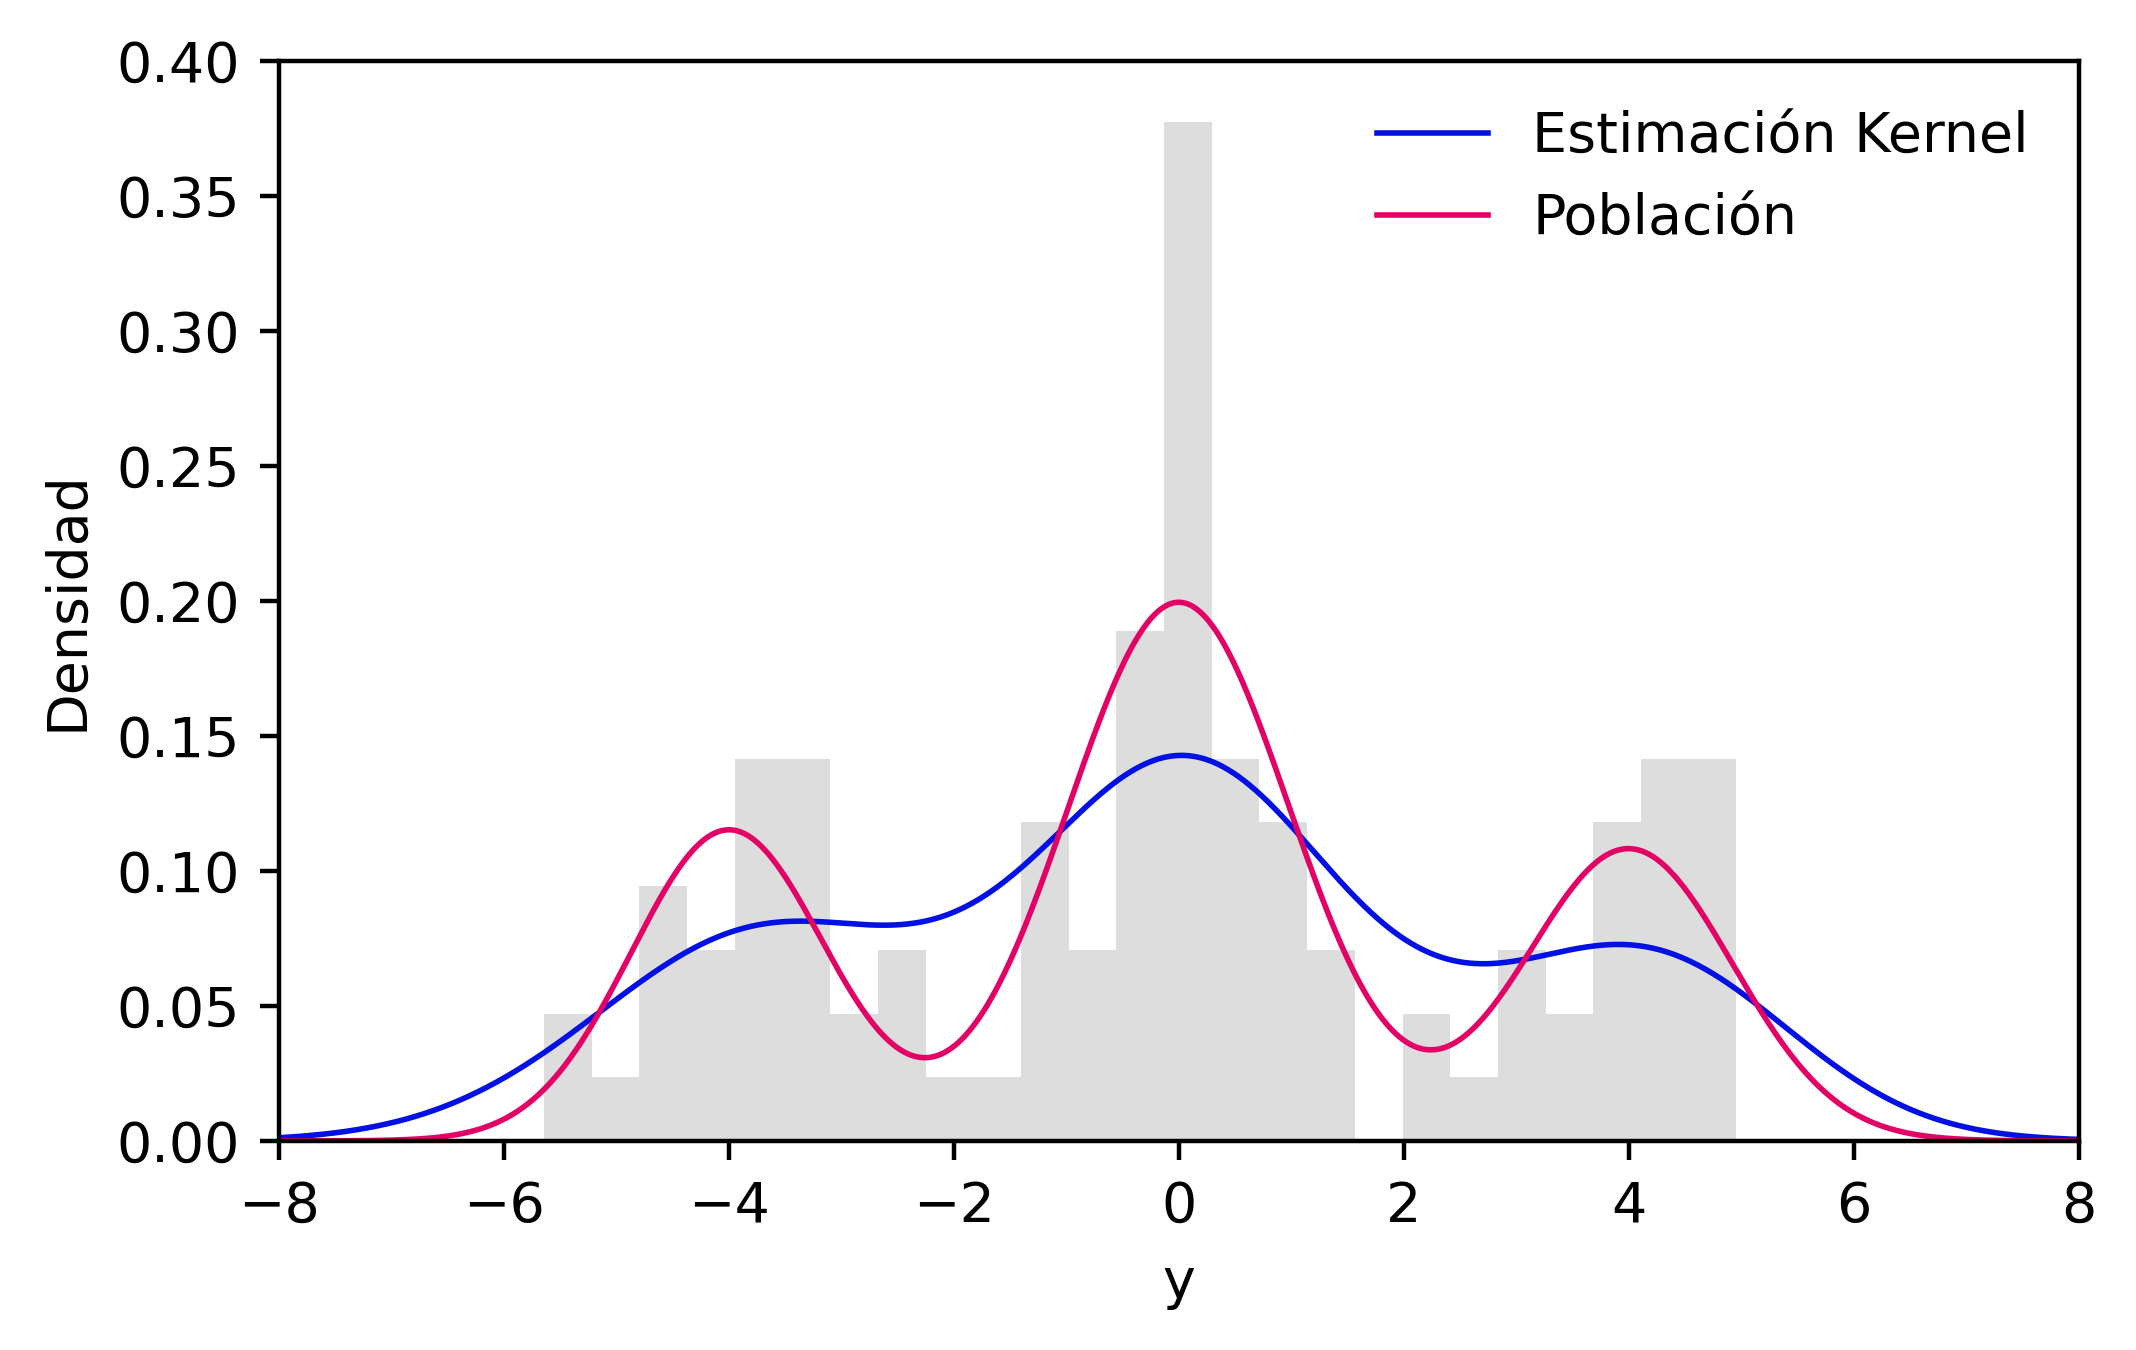

In [8]:
# valores poblacionales verdaderos
xi_true = xi
theta_true = theta
sig2_true = sig2
omega_true = omega
# función de densidad verdadera
def f_true(x):
    return np.sum(omega_true*st.norm.pdf(x,theta_true,scale = np.sqrt(sig2_true)))
# graficar data
f = plt.figure(figsize = (5,3), dpi = 400)
ax = f.add_axes([0.1,0.1,0.9,0.9])
# histograma
ax.hist(y,color = "#dddddd",bins = 25,density = True)
ax.set_xlim((-8,8))
ax.set_ylim((0,0.4))
ax.set_xlabel("y")
ax.set_ylabel("Densidad")
# Estimación kernel
x0 = np.linspace(-8,8,num = 1000)
ax.plot(x0,st.gaussian_kde(y)(x0),color = '#0110E4',linewidth = 1,label = "Estimación Kernel")
# funcion de densidad verdadera
y0 = [f_true(xi) for xi in x0]
ax.plot(x0,y0,color = '#E40165',linewidth = 1,label = "Población")
# leyenda
ax.legend(loc = 0, frameon = False)
#
plt.show()

## 5 Ejemplo: Datos de Galaxias

El conjunto de datos de galaxias fue publicado originalmente en astronomía por Postman et al. (1986) y consiste en mediciones univariadas que representan las **velocidades de las galaxias alejándose de nuestra galaxia**.

***Postman M, Huchra JP, Geller MJ (1986) Probes of large-scale structure in the Corona Borealis region. The Astron J 92(6):1238–1247.***

***Richardson, S., & Green, P. J. (1997). On Bayesian analysis of mixtures with an unknown number of components (with discussion). Journal of the Royal Statistical Society: series B (statistical methodology), 59(4), 731-792.***

***Grün, B., Malsiner-Walli, G., & Frühwirth-Schnatter, S. (2021). How many data clusters are in the Galaxy data set?. Advances in Data Analysis and Classification, 1-25.***


<img src = "agrupamiento_galaxias.jpg" width = 1000/> 

In [9]:
# data
# https://rdrr.io/cran/rebmix/man/galaxy.html
# Extraemos los datos de R con los siguientes comandos:
# > install.packages("rebmix")
# > library(rebmix)
# > data(galaxy)
# > write.csv(galaxy,"galaxy.csv",row.names = F)
galaxy = pd.read_csv("galaxy.csv")
y = galaxy.Velocity
n = len(y)

In [10]:
# inspeccionar data
y[:6]

0     9.172
1     9.558
2    10.406
3    18.419
4    18.927
5    19.330
Name: Velocity, dtype: float64

In [11]:
n

82

In [12]:
galaxy.describe()

,Velocity
count,82.000000
mean,20.831463
std,4.568135
min,9.172000
25%,19.532000
50%,20.833500
75%,23.133000
max,34.279000


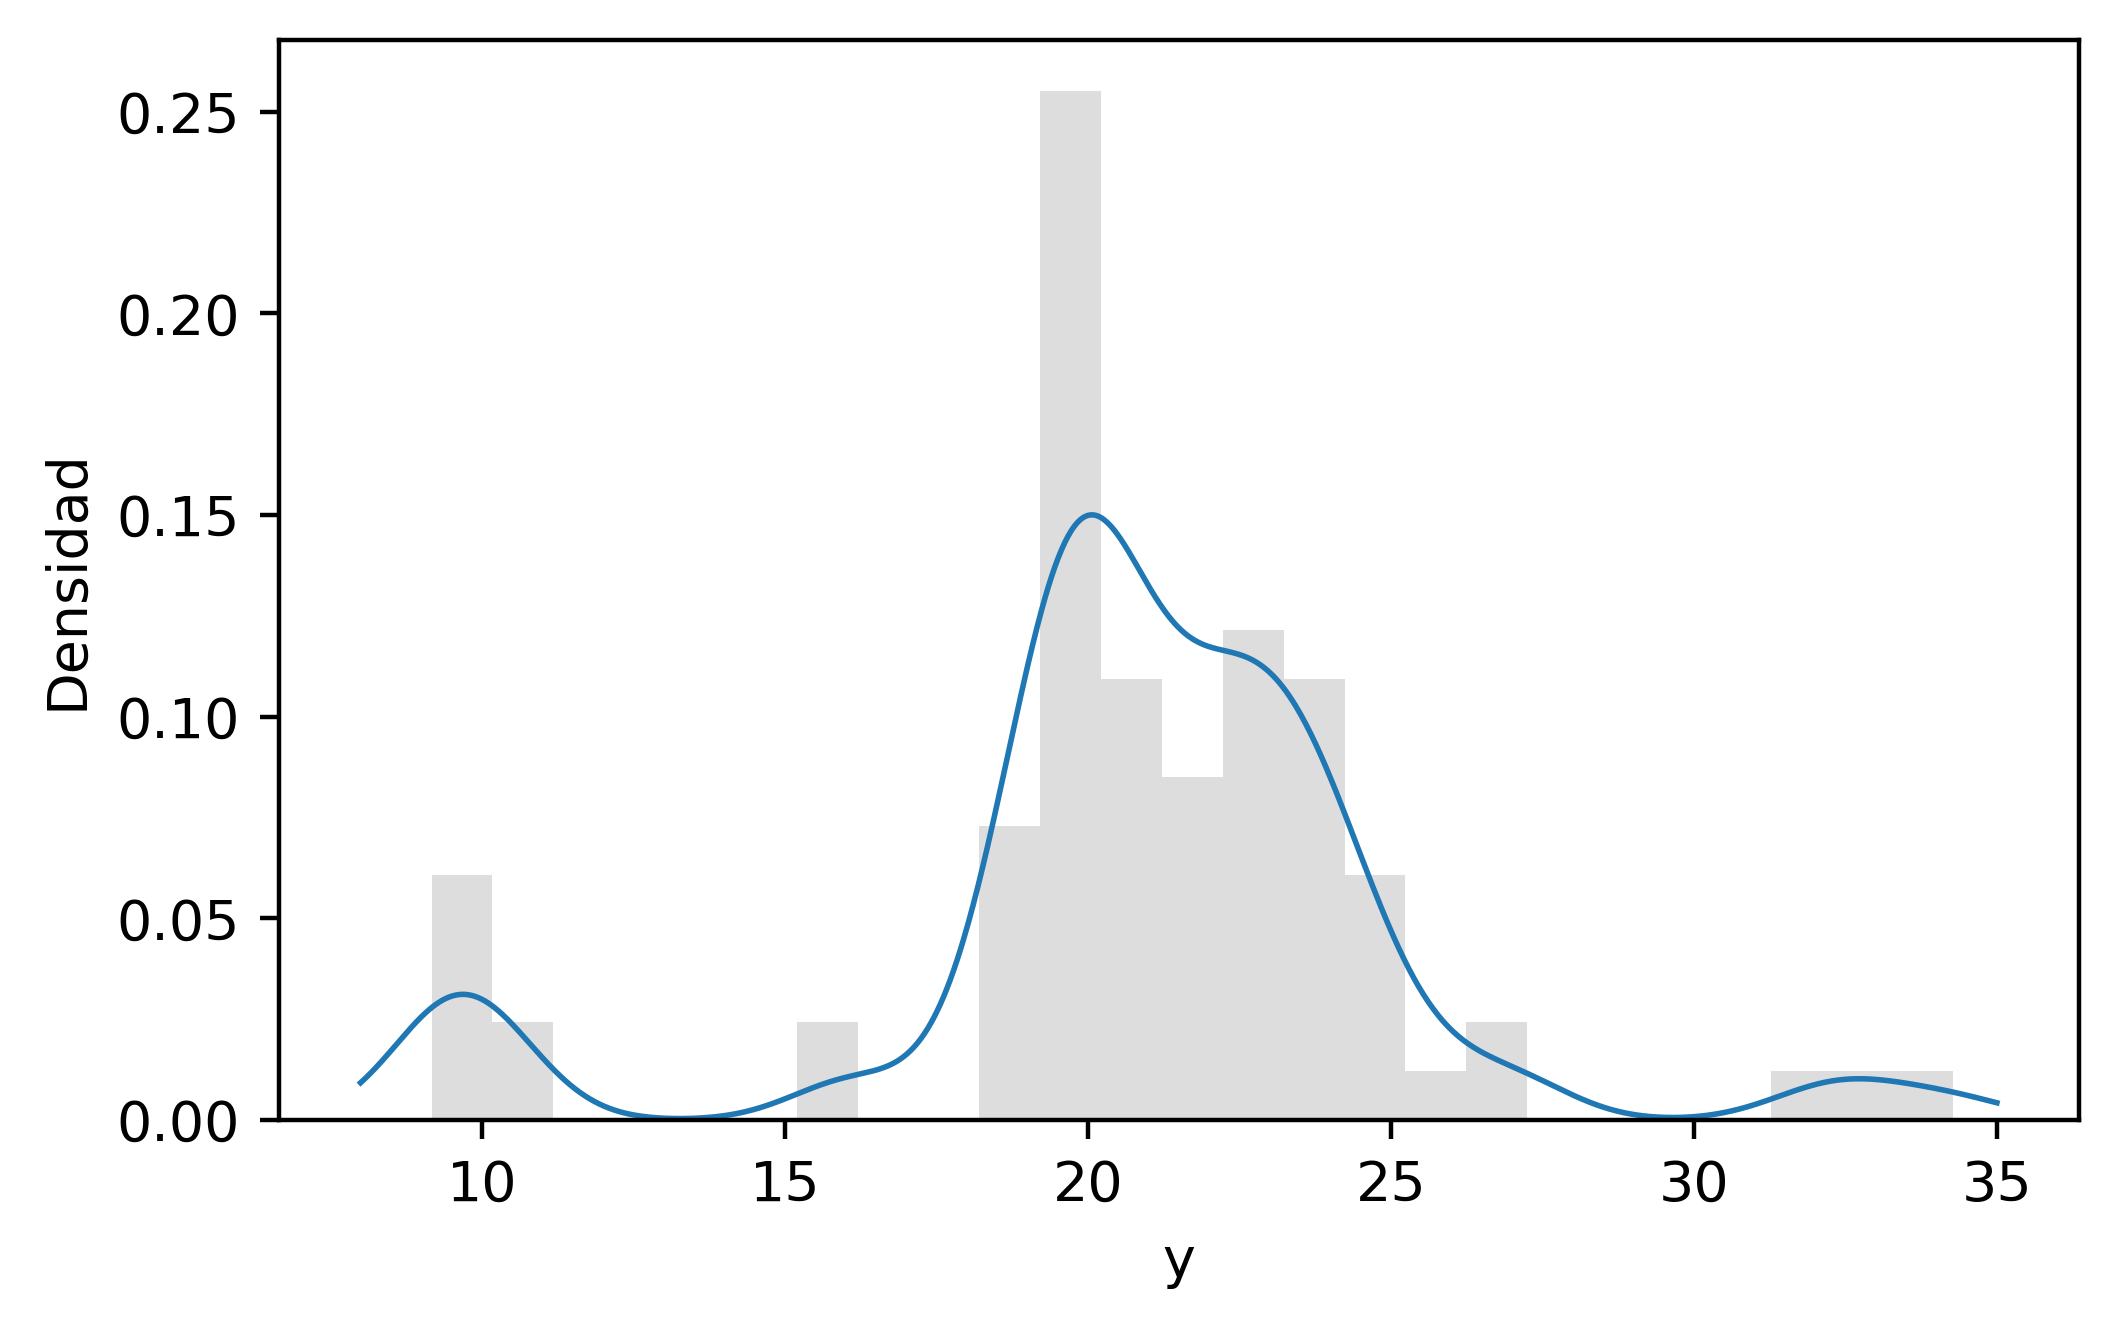

In [13]:
f = plt.figure(figsize = (5,3), dpi = 400)
ax = f.add_axes([0.1,0.1,0.9,0.9])
# histograma
ax.hist(y,color = "#dddddd",bins = 25,density = True)
ax.set_xlabel("y")
ax.set_ylabel("Densidad")
# estimación kernel
y_grid = np.linspace(8,35,num = 1000)
ax.plot(y_grid,st.gaussian_kde(y,bw_method = 0.22)(y_grid),linewidth = 1)
#
plt.show()

## 6 Estimación

Construir un **muestreador de Gibbs** para obtener muestras de la distribución posterior $p(\boldsymbol{\theta}\mid\boldsymbol{y})$ donde: 

- $\tev = (\xi_1,\ldots,\xi_n,\omega_1,\ldots,\omega_H,\te_1,\ldots,\te_H,\sigma^2)$.
- $\boldsymbol{y}=(y_1,\ldots,y_n)$.

Distribución **posterior**:

$$
\begin{align*}
p(\xiv,\omev,\tev,\sigma^2\mid\yv) &\propto \prod_{i=1}^n\Nor(y_i\mid\theta_{\xi_i},\sigma^2)\times\Cat(\xiv\mid\omev) \times\Dir(\omev)\times\prod_{h=1}^H\Nor(\theta_h\mid\mu_0,\gamma^2_0)\times\IG\left(\sigma^2\mid\tfrac{\nu_0}{2},\tfrac{\nu_0\sigma^2_0}{2}\right)\,.
\end{align*}
$$


Distribuciones **condicionales completas**:




1. La distribución condicional completa de $\theta_h$, para $h = 1,\ldots,H$, es $\theta_h\mid\text{resto}\sim\Nor(m_h,v^2_h)$ con:
	$$
	m_h = \frac{\frac{1}{\gamma_0^2}\mu_0 + \frac{n_h}{\sigma^2}\bar{y}_h}{\frac{1}{\gamma_0^2} + \frac{n_h}{\sigma^2}}
	\qquad\text{y}\qquad 
	v^2_h = \frac{1}{\frac{1}{\gamma_0^2} + \frac{n_h}{\sigma^2}}
	$$
	donde $n_h = |\{i:\xi_i=h\}|$ es el número de individuos del grupo $h$ y 
	$$
	\bar{y}_h = \frac{1}{n_h}\sum_{i:\xi_i=h}y_i
	$$ 
	es la media de las observaciones del grupo $h$. Finalmente, si $n_h = 0$, entonces $m_h = \mu_0$ y $v^2_h = \gamma_0^2$.
	

In [14]:
def sample_theta(nh,ybh,mu0,gamma02,sig2,theta):
    theta = theta.copy()
    for h in range(len(nh)):
        if nh[h] > 0:
            v2 = 1/(1/gamma02 + nh[h]/sig2)
            m  = v2*(mu0/gamma02 + nh[h]*ybh[h]/sig2)
        else:
            v2 = gamma02
            m  = mu0
        theta[h] = st.norm.rvs(m,scale = np.sqrt(v2))
    return theta

2. La distribución condicional completa de $\sigma^2$ es:
	$$
	\sigma^2\mid\text{resto}\sim\IG\left( \frac{\nu_0 + n}{2} , \frac{\nu_0\sigma_0^2 + \sum_{i=1}^n (y_i - \theta_{\xi_i})^2 }{2} \right)\,.
	$$

In [15]:
def sample_sig2(nu0, sig02, sig2, xi, theta, y):
    alpha = (nu0 + len(y))/2
    beta  = (nu0*sig02 + np.sum((y - theta[xi])**2))/2
    sig2 = st.invgamma.rvs(alpha,scale = beta)
    return sig2

3. La distribución condicional completa de $\xi_i$, para $i=1,\ldots,n$, es una distribución de probabilidad discreta tal que:
	$$
	p(\xi_i = h\mid\text{resto})\propto \omega_h\, \Nor(y_i\mid\theta_h,\sigma^2)
	$$
	y por lo tanto
	$$
	\textsf{Pr}(\xi_i = h\mid\text{resto}) = \frac{ \omega_h\, \Nor(y_i\mid\theta_h,\sigma^2) }{ \sum_{h=1}^H \omega_k\, \Nor(y_i\mid\theta_{h},\sigma^2) }
	$$
	para $h = 1,\ldots,H$.

In [16]:
def sample_xi(omega, sig2, xi, theta, y):
    H = len(omega)
    xi = xi.copy()
    for i in range(len(y)):
        lp = np.zeros(H)
        for h in range(H):
            lp[h] = np.log(omega[h]) + st.norm.logpdf(y[i],theta[h],scale = np.sqrt(sig2))
        xi[i] = np.random.choice(range(H),p = np.exp(lp)/np.sum(np.exp(lp)))
    return xi

4. La distribución condicional completa de $\omev$ es:
	$$
	\omev\mid\text{resto} \sim \Dir(\alpha^0_1+n_1,\ldots,\alpha^0_{H}+n_H)\,.
	$$


In [17]:
def sample_omega(nh, alpha0, omega):
    omega = st.dirichlet.rvs(alpha0 + nh)[0]
    return omega

## 7 Ejemplo: Datos Sintéticos

Muestra aleatoria de tamaño $n = 1000$ de la siguiente mezcla:
$$
y_i \simiid 0.25\Nor(-4,0.75) + 0.5\Nor(0,1) + 0.25\Nor(4,0.85)\,.
$$

In [18]:
# simular data
n = 100
y = None
H = 3
omega = np.array([0.25, 0.5, 0.25])
theta = np.array([-4, 0, 4])
sig2  = np.array([0.75, 1, 0.85])
np.random.seed(1)
xi = np.random.choice(a = range(H),replace = True, p = omega,size = n)
y = st.norm.rvs(theta[xi], scale = np.sqrt(sig2[xi]),size = n)

### 7.1 Muestreador de Gibbs

In [19]:
def table(x,H):
    fr = []
    for i in range(H):
        fr.append(np.sum(x == i))
    return fr

In [20]:
def MCMC_agrupamiento(n_sams, n_burn, y, H, alpha0, mu0, gamma02, nu0, sig02, verbose = True):
    # número total de iteraciones
    B = n_sams + n_burn
    ncat = np.floor(0.1*B)
    # valores iniciales
    np.random.seed(1)
    theta = np.full(H,np.mean(y))
    sig2 = np.var(y,ddof = 1)
    omega = np.full(H,1/H)
    xi = np.random.choice(range(H),p = omega,replace = True,size = len(y))
    # almacenamiento
    THETA  = []
    SIG2   = []
    OMEGA  = []
    XI     = []
    LP     = []
    # cadena
    np.random.seed(1)
    for i in range(B):
        # actualizar estadísticos suficientes
        nh = table(xi,H)
        ybh = [(np.mean(y[xi == h]) if nh[h]>0 else None) for h in range(H)]
        # actualizar parámetros
        theta = sample_theta(nh,ybh,mu0,gamma02,sig2,theta)
        sig2  = sample_sig2(nu0,sig02,sig2,xi,theta,y)
        omega = sample_omega(nh,alpha0,omega)
        xi    = sample_xi(omega,sig2,xi,theta,y)
        # almacenar y log-verosimilitud
        if i >= n_burn:
            THETA.append(theta)
            SIG2.append(sig2)
            OMEGA.append(omega)
            XI.append(xi)
            LP.append(np.sum(
                st.norm.logpdf(y,theta[xi],scale = np.sqrt(sig2))
            ))
        # progreso
        if verbose:
            if i%ncat == 0:
                print(100*np.round(i/B,decimals = 1),"% completado",sep = '')
    return {'THETA' : THETA, 'SIG2' : SIG2, 'OMEGA' : OMEGA, 'XI' : XI, 'LP' : LP}

### 7.2 Ajuste del modelo

Muestras de la distribución posterior $p(\xiv,\omev,\tev,\sigma^2\mid\yv)$ usando un **muestreador de Gibbs** con:

- $H = 3$.
- $\alpha^0_1=\alpha^0_2=\alpha^0_3=1/3,\mu_0 = 0,\gamma_0^2 = s^2_y,\nu_0 = 1,\sigma^2_0 = s^2_y$. 


In [21]:
# número de grupos
H = 3

In [22]:
# hiperparámetros
alpha0  = np.full(H, 1/H)
mu0     = 0
gamma02 = np.var(y,ddof = 1)
nu0     = 1
sig02   = np.var(y,ddof = 1)

In [23]:
# número de parámetros
n + 2*H + 1

107

In [24]:
# numero de iteraciones
n_burn = 0
n_sams = 2500
t = time.time()
np.random.seed(123)
muestras = MCMC_agrupamiento(n_sams, n_burn, y, H, alpha0, mu0, gamma02, nu0, sig02) 
print(time.time() - t,"sec elapsed")

0.0% completado
10.0% completado
20.0% completado
30.0% completado
40.0% completado
50.0% completado
60.0% completado
70.0% completado
80.0% completado
90.0% completado
166.46865606307983 sec elapsed


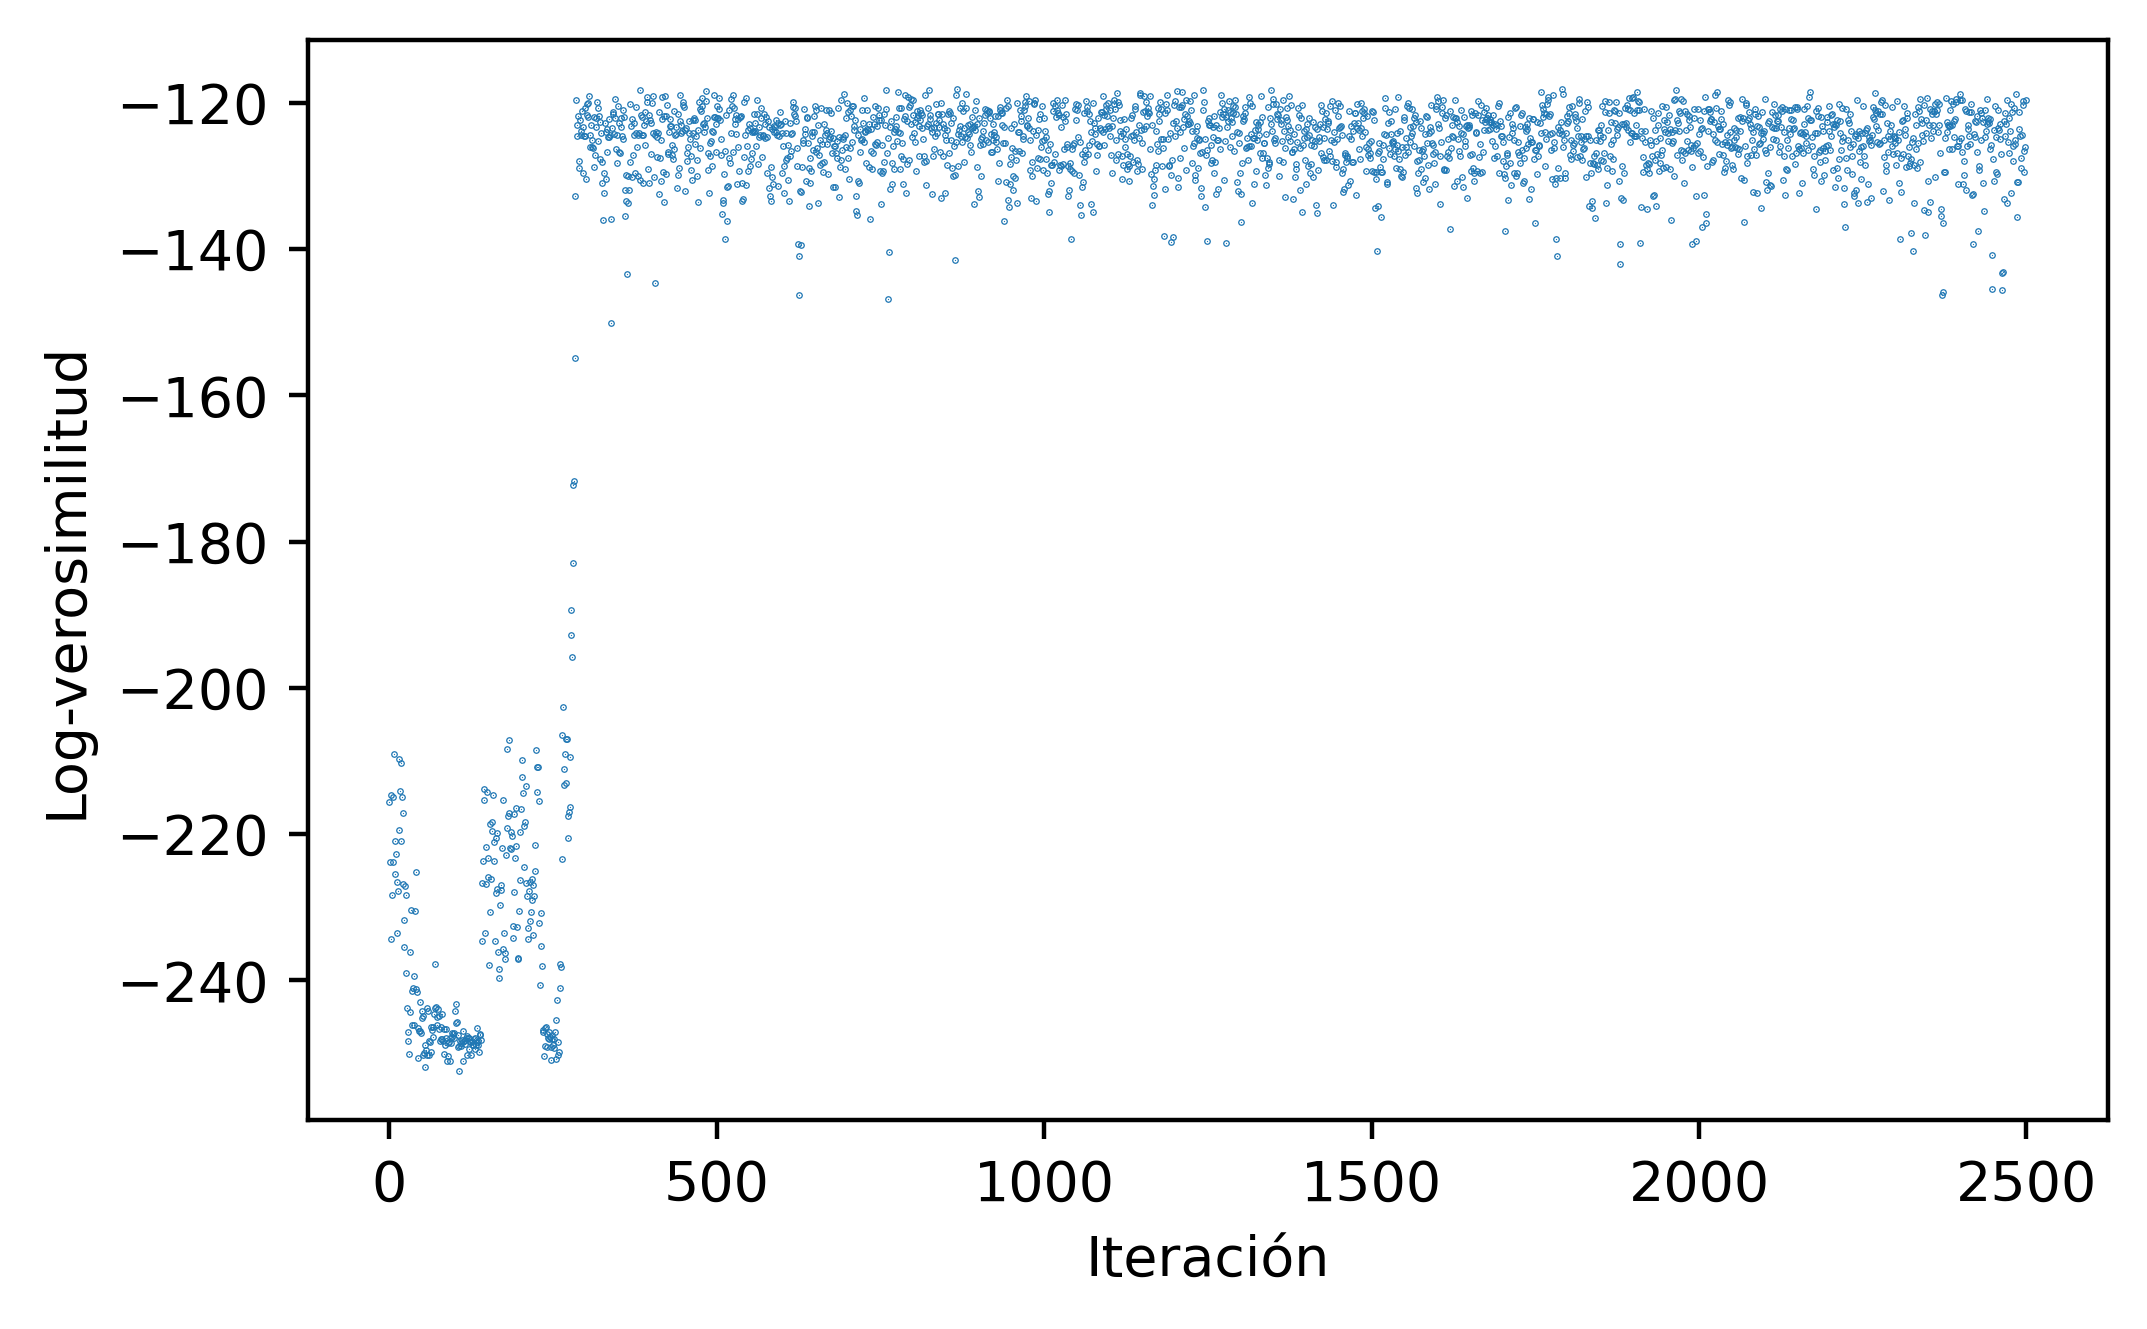

In [25]:
f = plt.figure(figsize = (5,3), dpi = 400)
ax = f.add_axes([0.1,0.1,0.9,0.9])
ax.scatter(range(n_sams),muestras['LP'],s = 0.05)
ax.set_xlabel("Iteración")
ax.set_ylabel("Log-verosimilitud")
plt.show()

In [26]:
# numero de iteraciones
n_burn = 600
n_sams = 2500
t = time.time()
np.random.seed(123)
muestras = MCMC_agrupamiento(n_sams, n_burn, y, H, alpha0, mu0, gamma02, nu0, sig02) 
print(time.time() - t,"sec elapsed")

0.0% completado
10.0% completado
20.0% completado
30.0% completado
40.0% completado
50.0% completado
60.0% completado
70.0% completado
80.0% completado
90.0% completado
154.47416520118713 sec elapsed


### 7.3 Convergencia

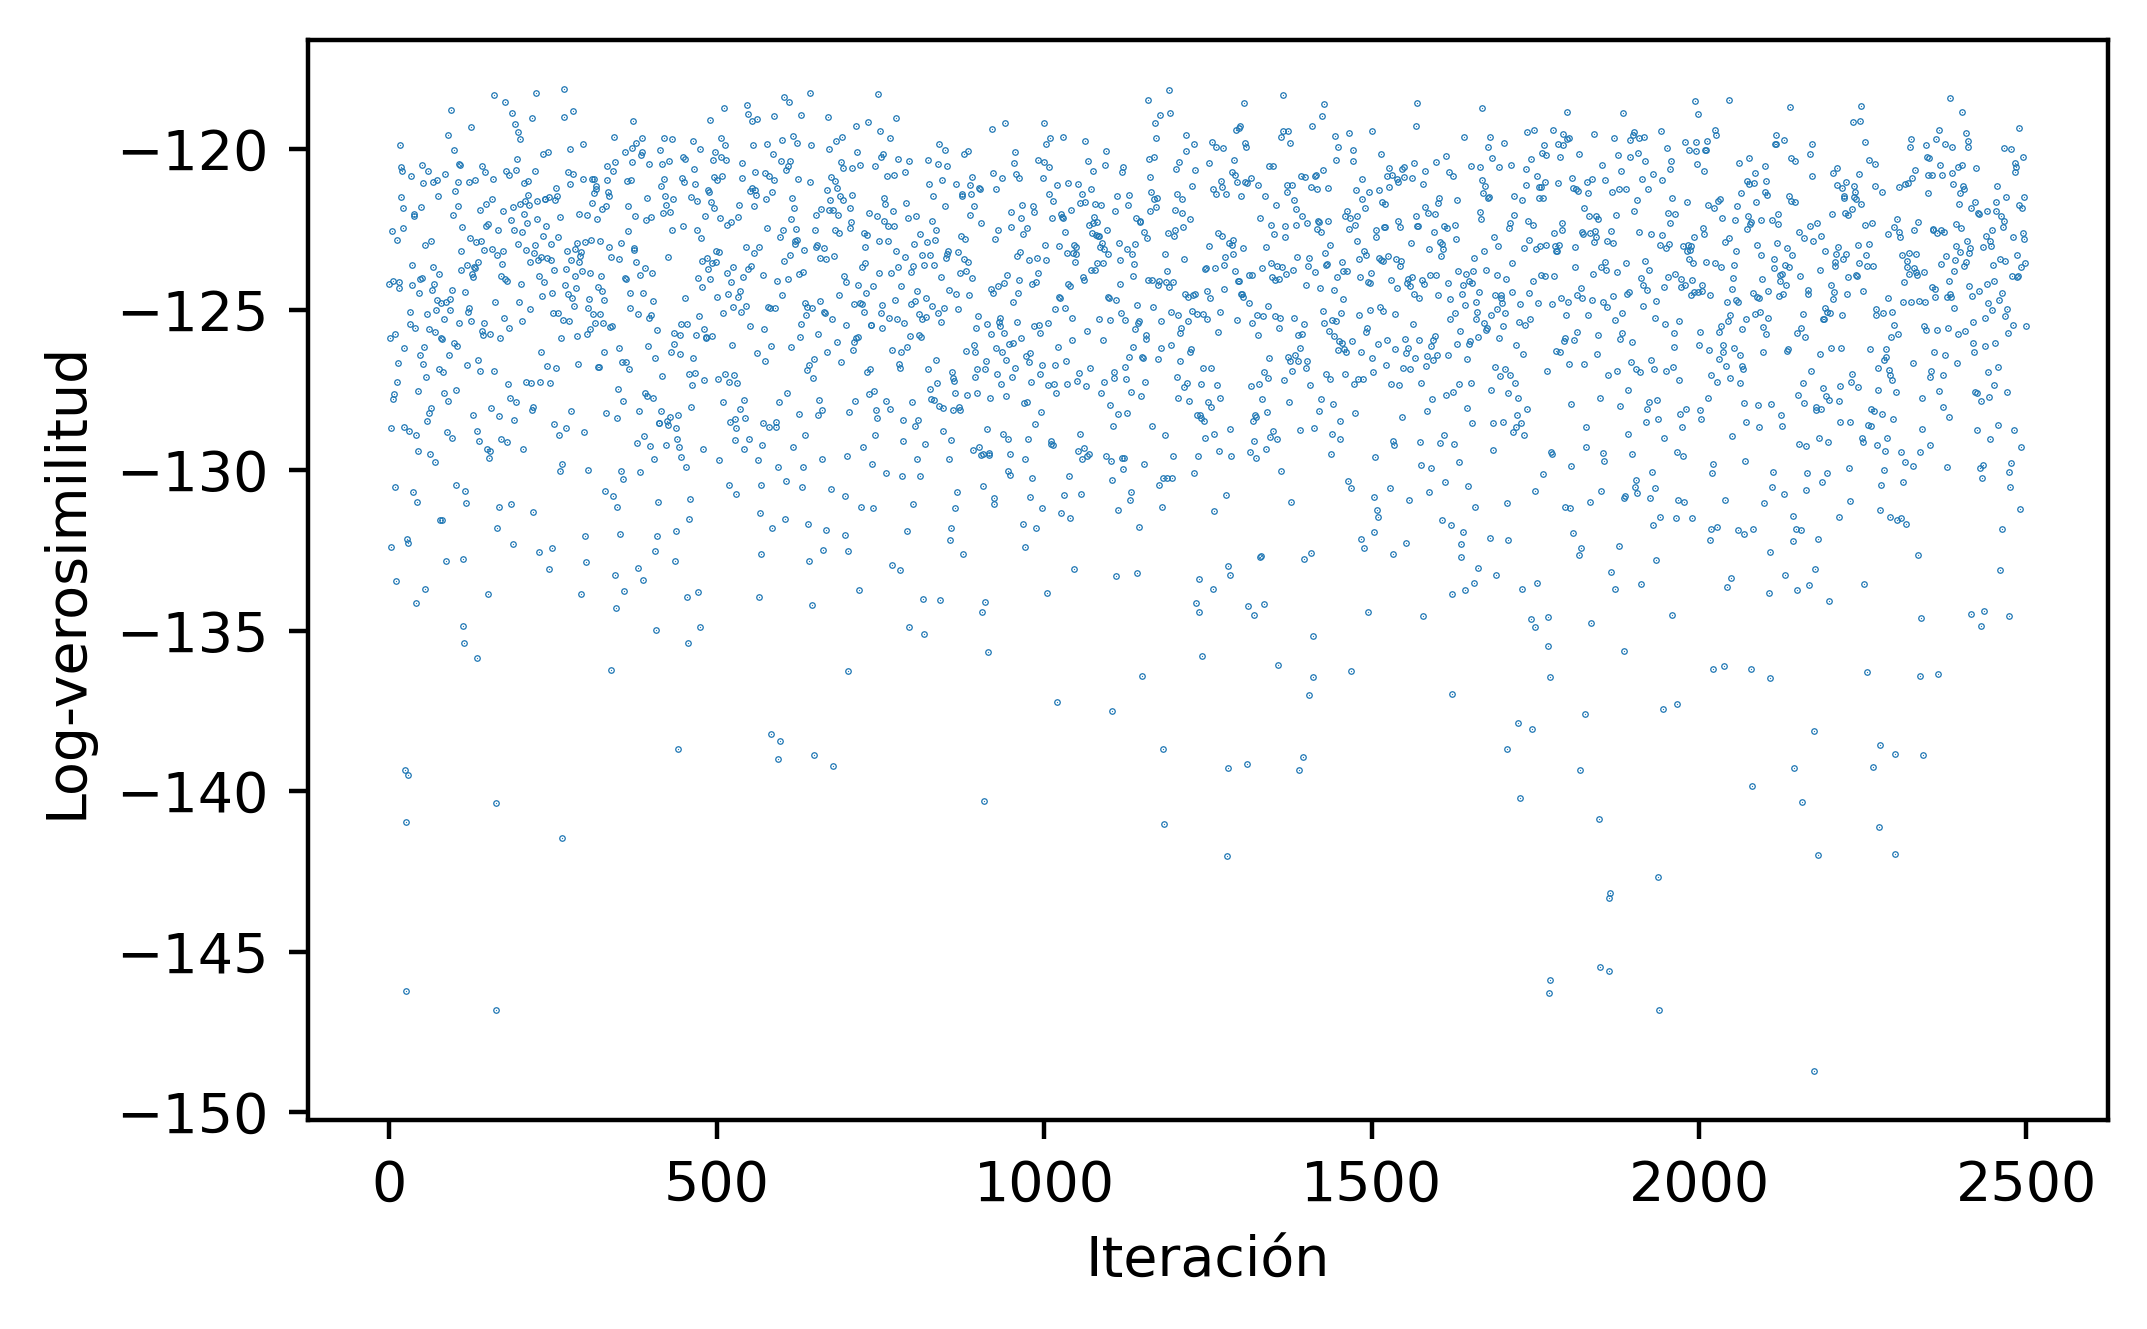

In [27]:
f = plt.figure(figsize = (5,3), dpi = 400)
ax = f.add_axes([0.1,0.1,0.9,0.9])
ax.scatter(range(n_sams),muestras['LP'],s = 0.05)
ax.set_xlabel("Iteración")
ax.set_ylabel("Log-verosimilitud")
plt.show()

In [28]:
# errores estandar de Monte Carlo
neff = [ess(np.array(muestras['THETA'])[:,k]) for k in range(H)]
std = [np.std(np.array(muestras['THETA'])[:,k]) for k in range(H)]
EEMC = std/np.sqrt(neff)
np.round(EEMC,decimals = 5)

array([0.00429, 0.00378, 0.00462])

In [29]:
neff = ess(np.array(muestras['SIG2']))
std = np.std(muestras['SIG2'])
EEMC = std/np.sqrt(neff)
np.round(EEMC,decimals = 5)

0.00357

In [30]:
neff = [ess(np.array(muestras['OMEGA'])[:,k]) for k in range(H)]
std = [np.std(np.array(muestras['OMEGA'])[:,k]) for k in range(H)]
EEMC = std/np.sqrt(neff)
np.round(EEMC,decimals = 5)

array([0.00092, 0.00112, 0.00108])

### 7.4 Inferencia: Medias, varianzas, probabilidades

In [31]:
# resumen posterior
def resumen_pos(x):
    return np.concatenate(([np.mean(x), np.std(x)] , np.quantile(x,q = [0.025,0.975])))

In [32]:
tab = [
    resumen_pos(np.array(muestras['THETA'])[:,0]),
    resumen_pos(np.array(muestras['THETA'])[:,1]),
    resumen_pos(np.array(muestras['THETA'])[:,2]),
    resumen_pos(np.array(muestras['SIG2'])),
    resumen_pos(np.array(muestras['OMEGA'])[:,0]),
    resumen_pos(np.array(muestras['OMEGA'])[:,1]),
    resumen_pos(np.array(muestras['OMEGA'])[:,2])
]
tab = pd.DataFrame(tab,
             columns = ['Media','SD','Q2.5%','Q97.5%'],
             index = ['theta_'+str(h) for h in range(H)] + ['sig2'] + ['omega_' + str(h) for h in range(H)]
)
round(tab,3)

,Media,SD,Q2.5%,Q97.5%
theta_0,3.919,0.193,3.536,4.315
theta_1,0.008,0.146,-0.274,0.294
theta_2,-3.742,0.182,-4.089,-3.387
sig2,0.804,0.136,0.590,1.104
omega_0,0.242,0.044,0.160,0.327
omega_1,0.482,0.051,0.382,0.583
omega_2,0.275,0.046,0.190,0.373



- Los **valores reales** de los parámetros están **dentro** de los **intervalos de credibilidad**.
- Las **etiquetas** (*labels*) de los grupos **no son identificables** (intercambiar las etiquetas no cambia la verosimilitud, esto se conoce como *Label switching*). Las etiquetas per se no son de interés, lo que interesa verdaderamente son los **miembros de los grupos**.


In [33]:
# inferencia sobre la función de densidad de la población
M = 100
x0 = np.linspace(-8,8,num = M)
y0 = np.zeros(M)
B = len(muestras['XI'])
FE = np.empty((B,M))
for i in range(M):
    y0[i] = f_true(x0[i])
    for b in range(B):
        FE[b,i] = np.sum(
            np.array(muestras['OMEGA'])[b,:]*st.norm.pdf(x0[i],
                                                         np.array(muestras['THETA'])[b,:],
                                                         scale = np.sqrt(muestras['SIG2'][b])
                                                        )
        )
f_hat = np.mean(FE,axis = 0)
f_inf = np.quantile(FE,q = 0.025,axis = 0)
f_sup = np.quantile(FE,q = 0.975,axis = 0)

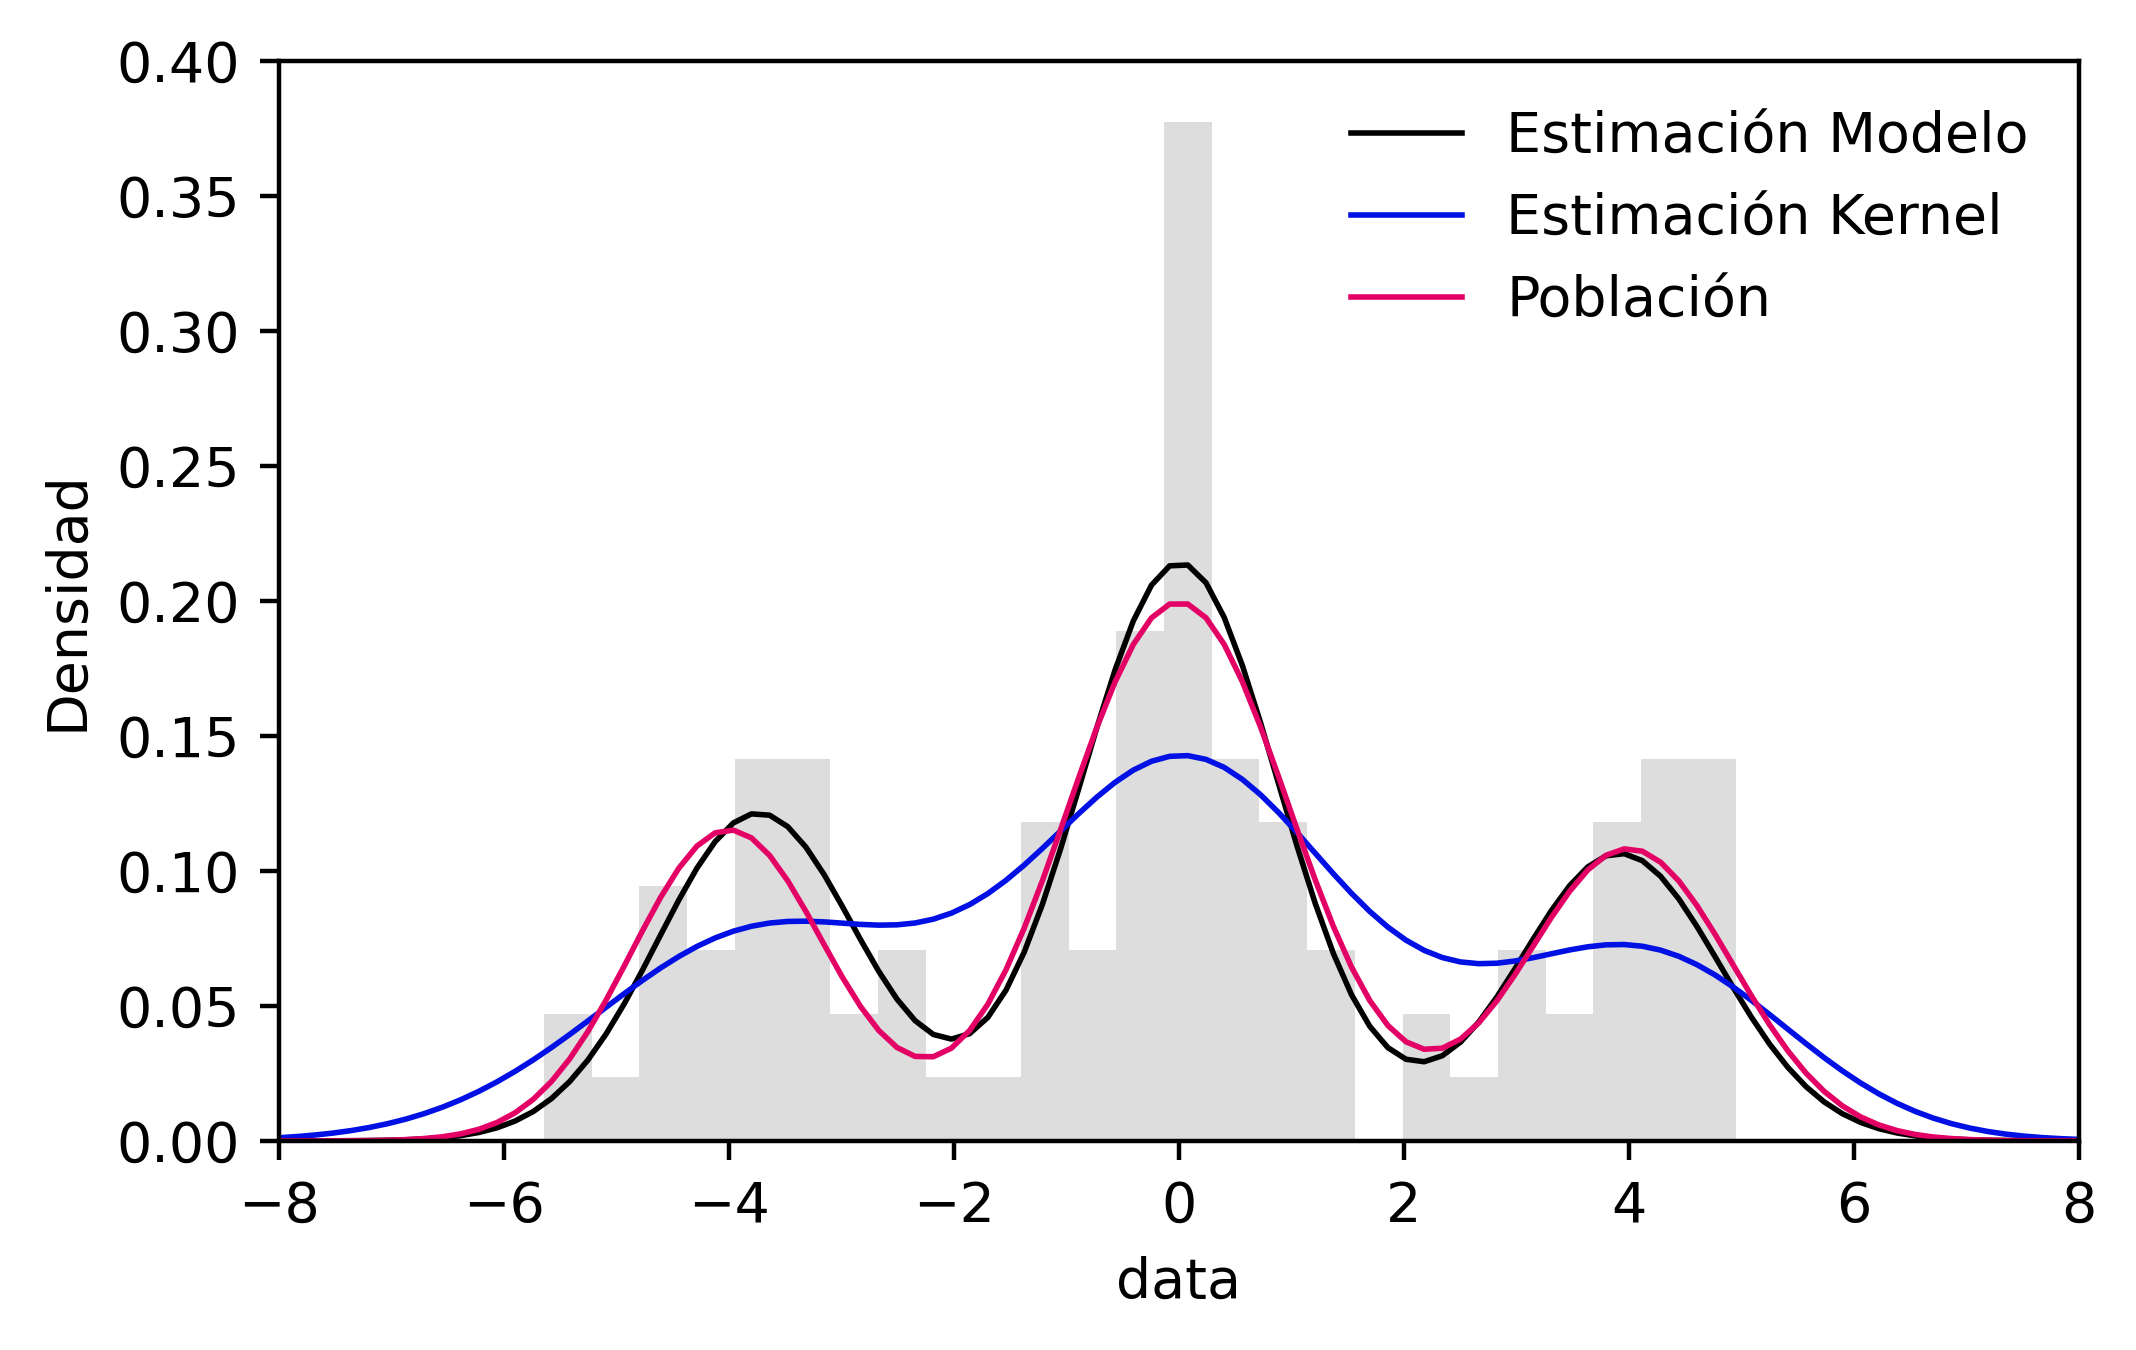

In [34]:
f = plt.figure(figsize = (5,3), dpi = 400)
ax = f.add_axes([0.1,0.1,0.9,0.9])
# histograma
ax.hist(y,color = "#dddddd",bins = 25,density = True)
ax.set_xlim((-8,8))
ax.set_ylim((0,0.4))
ax.set_xlabel("data")
ax.set_ylabel("Densidad")
# estimacion modelo
ax.plot(x0,f_hat, color = 'black',linewidth = 1, label = "Estimación Modelo")
# estimación kernel
ax.plot(x0,st.gaussian_kde(y)(x0),color = '#0110E4',linewidth = 1,label = "Estimación Kernel")
# funcion de densidad verdadera
ax.plot(x0,y0,color = '#E40165',linewidth = 1,label = "Población")
# leyenda
ax.legend(loc = 0, frameon = False)
#
plt.show()

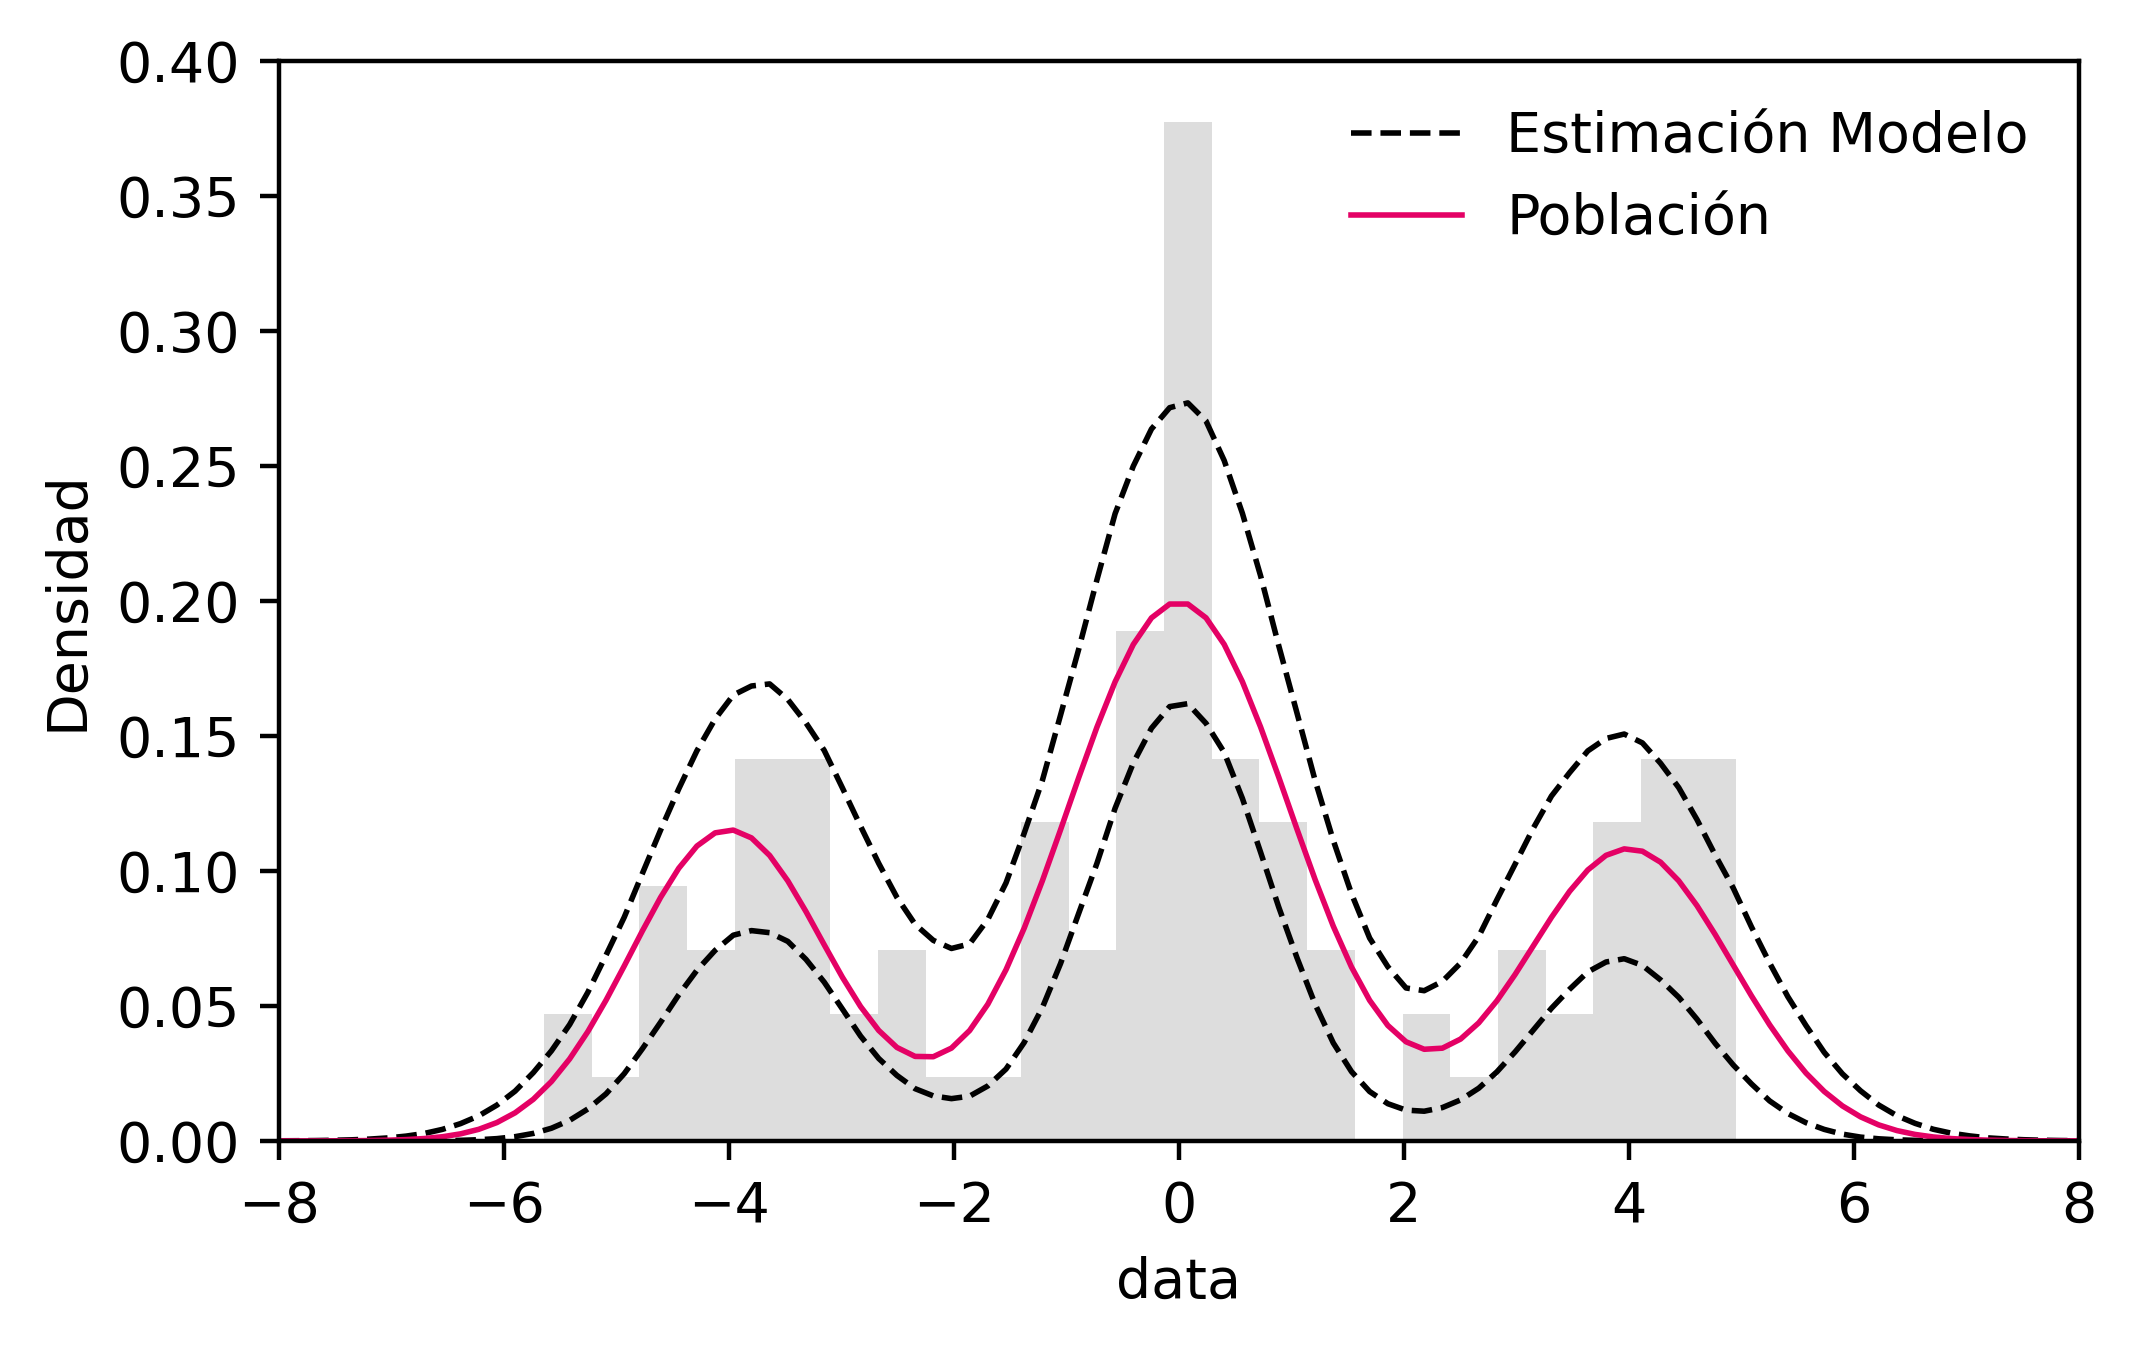

In [35]:
f = plt.figure(figsize = (5,3), dpi = 400)
ax = f.add_axes([0.1,0.1,0.9,0.9])
# histograma
ax.hist(y,color = "#dddddd",bins = 25,density = True)
ax.set_xlim((-8,8))
ax.set_ylim((0,0.4))
ax.set_xlabel("data")
ax.set_ylabel("Densidad")
# estimacion modelo
ax.plot(x0,f_inf, color = 'black',linewidth = 1,ls='--',label = "Estimación Modelo")
ax.plot(x0,f_sup, color = 'black',linewidth = 1,ls='--')
# funcion de densidad verdadera
ax.plot(x0,y0,color = '#E40165',linewidth = 1,label = "Población")
# leyenda
ax.legend(loc = 0, frameon = False)
#
plt.show()

La estimación usando el modelo es claramente mejor que la estimación por no paramétrica (kernel), dado que la estimación puntual usando el modelo se 
encuentra mas "cercana" de la función de densidad de la población, la cual ademas se encuentra incluida dentro de las bandas de confianza.


### 7.5 Inferencia: Grupos

La **matriz de incidencia** $\mathbf A = [a_{i,j}]$ es una matriz cuadrada de $n\times n$ constituida por las **probabilidades pareadas de que las observaciones $i$ y $j$ pertenezcan al mismo grupo**, esto es, 
$$
a_{i,j} = \textsf{Pr}(\xi_i = \xi_j \mid \boldsymbol{y}) \approx \frac{1}{B}\sum_{b=1}^B \mathbb I\left\{ \xi_i^{(b)} = \xi_j^{(b)} \right\} \,.
$$
La matriz $\mathbf A$ es simétrica dado que $\textsf{Pr}(\xi_i = \xi_j \mid \boldsymbol{y}) = \textsf{Pr}(\xi_j = \xi_i \mid \boldsymbol{y})$, y además, $a_{i,i} = \textsf{Pr}(\xi_i = \xi_i \mid \boldsymbol{y}) = 1$, para todo $i$.


In [36]:
A = np.zeros((n,n))
B = len(muestras['XI'])
for i in range(n-1):
    for j in range(i+1,n):
        A[i,j] += np.sum(np.array(muestras['XI'])[:,i] == np.array(muestras['XI'])[:,j])/B
A = A + A.T
A[range(n),range(n)] = 1     

In [37]:
# gráfico de la matriz de incidencia
# primero se organizan las observaciones de acuerdo a la partición verdadera
# para facilitar la visualización de las probabilidades
indices = np.argsort(xi_true)
A = A[indices,:][:,indices]

In [38]:
def heat_plot0(mat,show_grid = False, cex_axis = 2, tick = True,labs = None,**args):
    JJ = mat.shape[0]
    mat = mat.copy()[np.flip(range(JJ)),:]
    if labs is None:
        labs = range(JJ)
    # adjacency matrix
    f = plt.figure(figsize = (3,3), dpi = 500)
    ax = f.add_axes([0.1,0.1,0.9,0.9])
    ax.imshow(mat,cmap = "gist_heat_r",vmin = 0, vmax = 2)
    if tick:
        ax.set_xticks(ticks = range(JJ),
                     labels = labs)
        ax.set_yticks(ticks = range(JJ),
                     labels = np.flip(labs))
        ax.tick_params(axis='both', labelsize=cex_axis)
    if show_grid:
        ax.grid()
    return f,ax

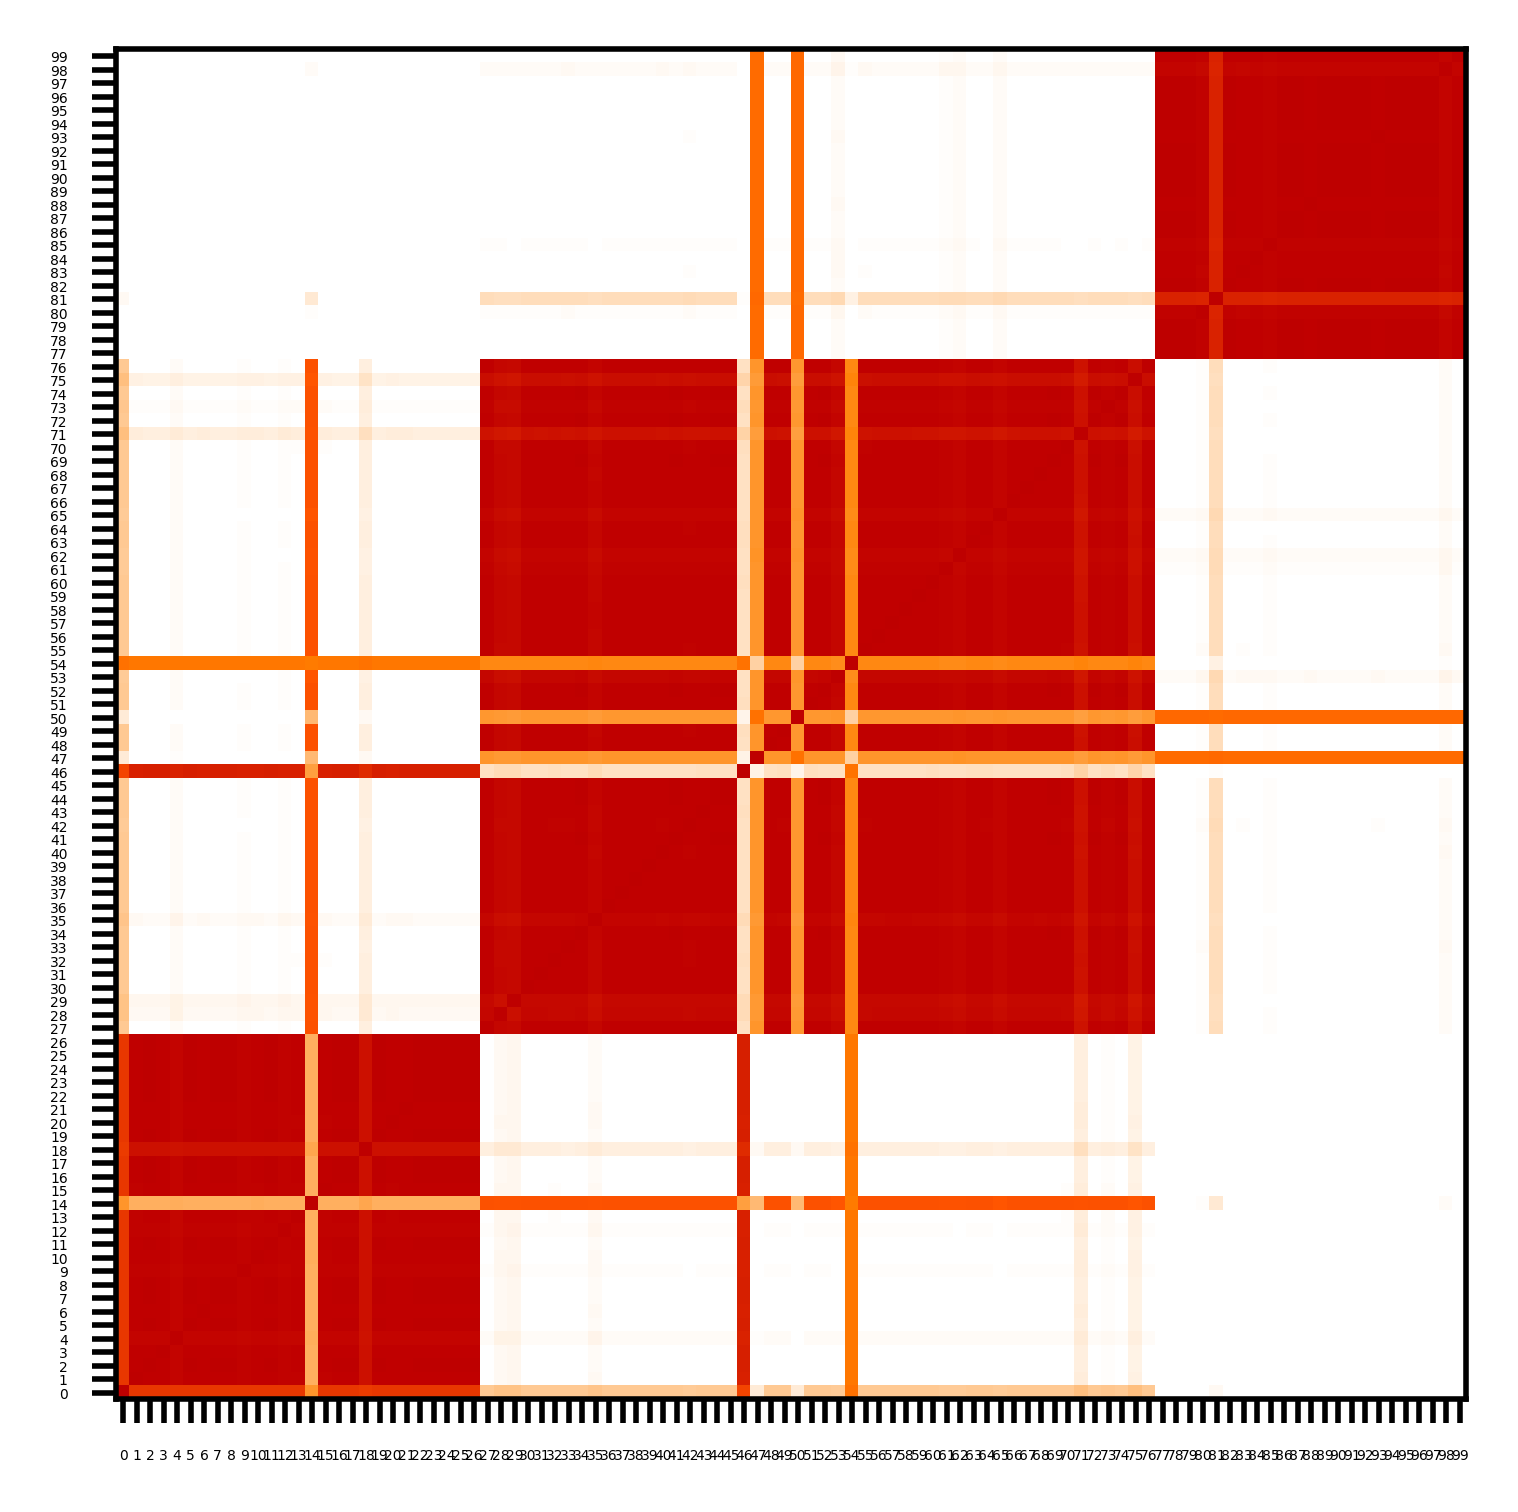

In [39]:
heat_plot0(A)
plt.show()


- Los **tres grupos se recuperan** perfectamente porque se evidencian **tres grandes grupos con altas probabilidades a posteriori** de pertenecer al mismo grupo.


In [40]:
# ARI: Adjusted Rand Index
# Medida normalizada de la similitud entre dos agrupaciones de datos
# 0.90 <= ARI        : excelente 
# 0.80 <= ARI < 0.90 : sobresaliente
# 0.60 <= ARI < 0.80 : moderado
# 0.50 <= ARI < 0.60 : aceptable
#         ARI < 0.50 : deficiente

def rand_index_score(clusters, classes):
# Taken from: https://stats.stackexchange.com/questions/89030/rand-index-calculation
    tp_plus_fp = comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

B = len(muestras['XI'])
ri  = np.zeros(B)
ari = np.zeros(B)
for b in range(B):
    ri[b]  = rand_index_score(np.array(muestras['XI'])[b,:],
                             xi_true)
    ari[b] = adjusted_rand_score(np.array(muestras['XI'])[b,:],
                             xi_true)

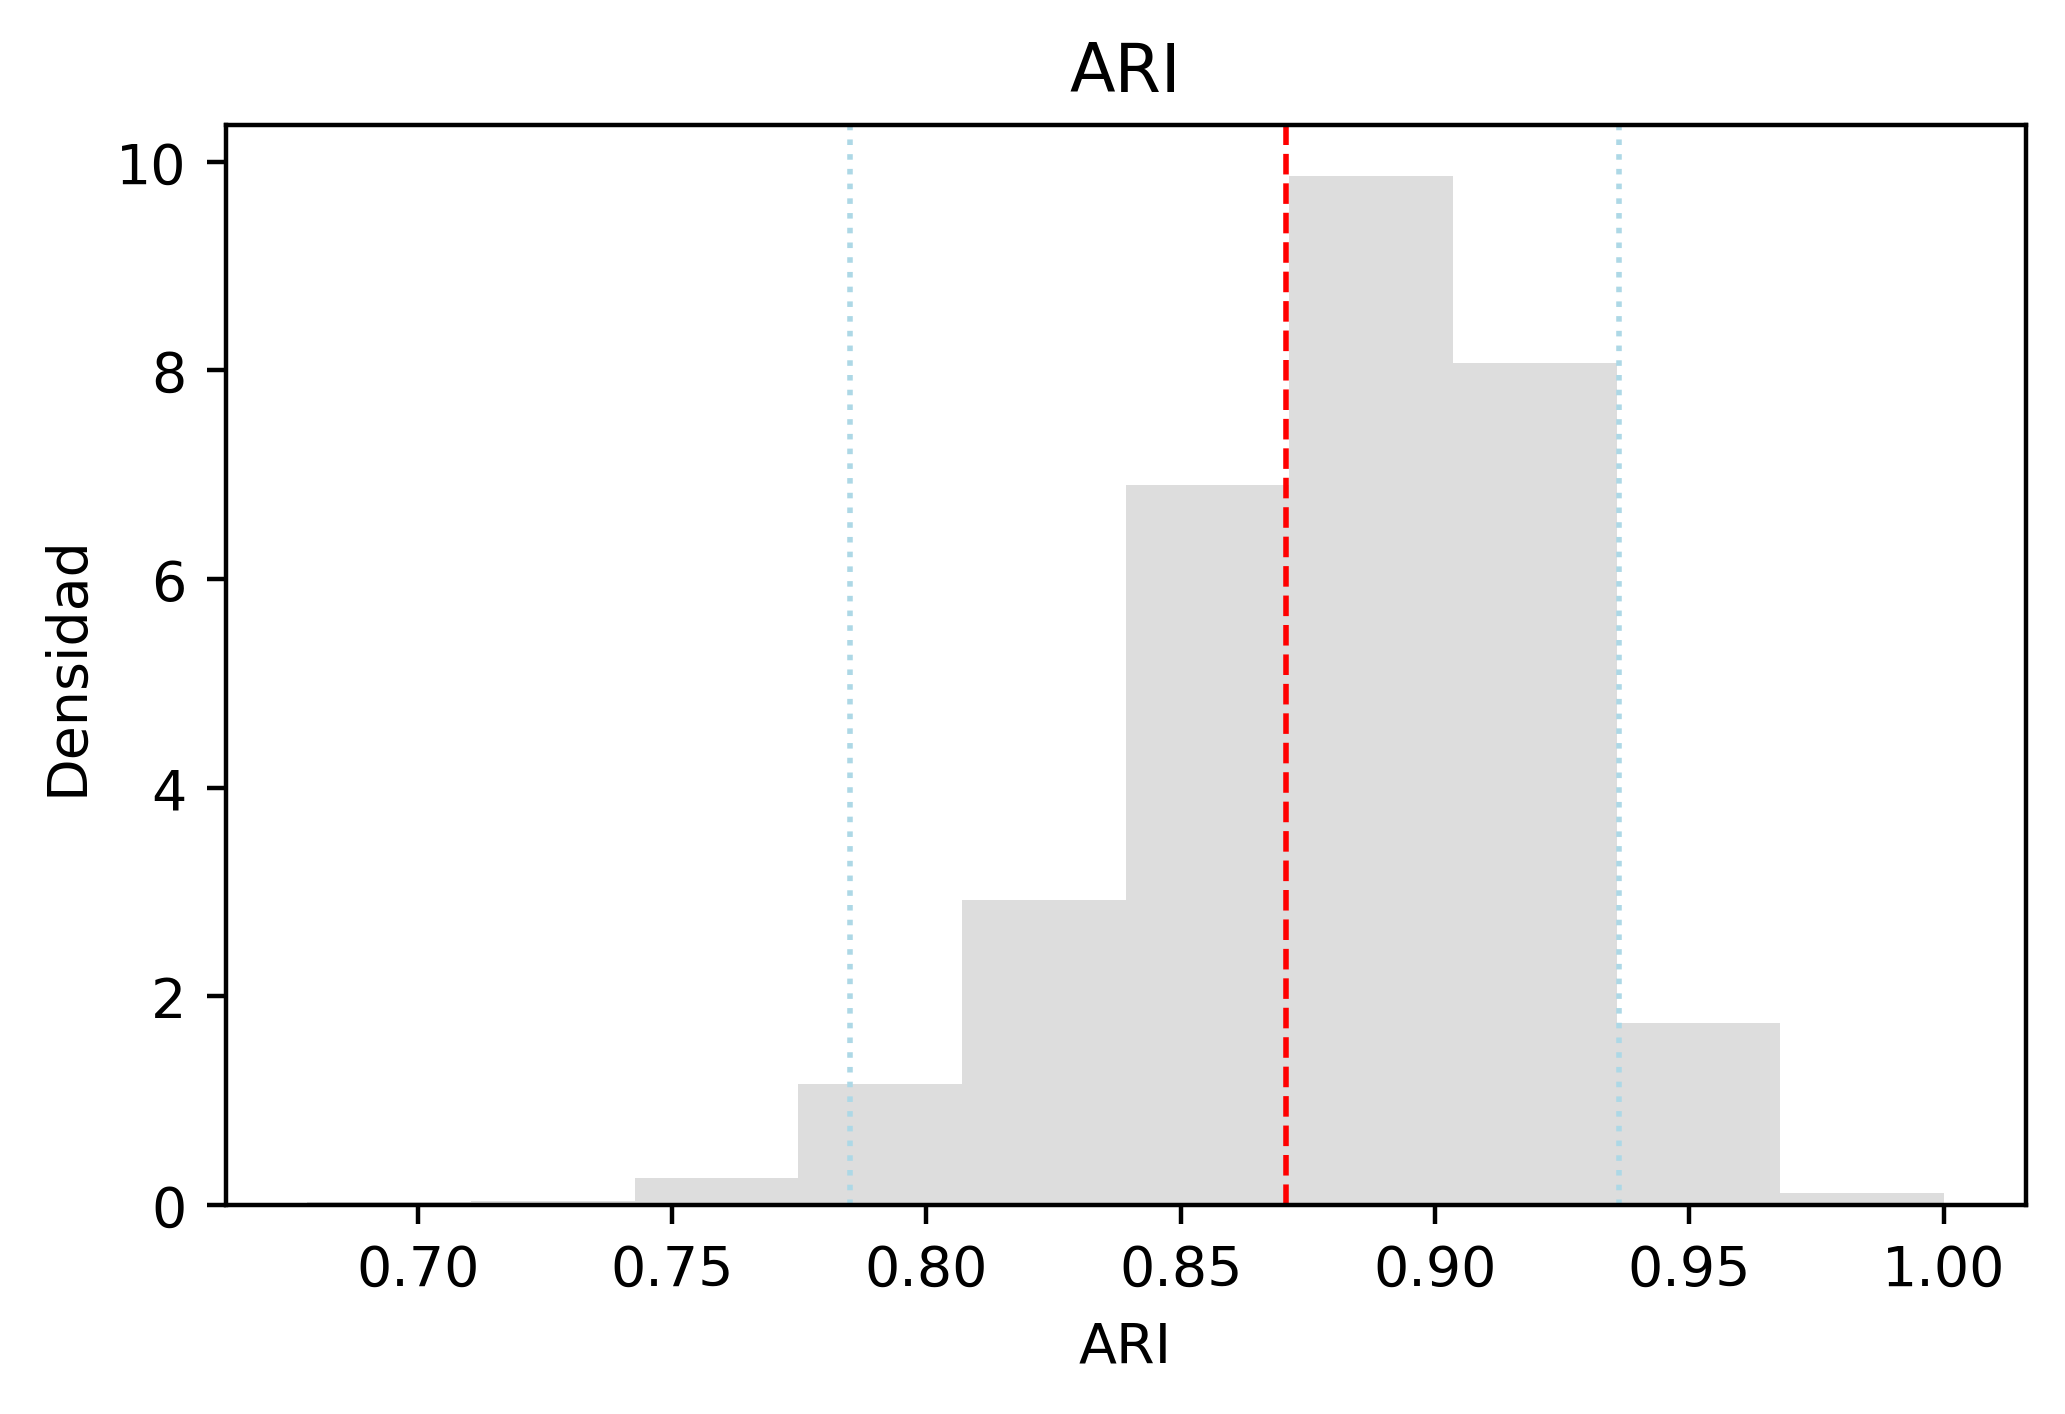

In [41]:
# grafico ari
f = plt.figure(figsize = (5,3), dpi = 400)
ax = f.add_axes([0.1,0.1,0.9,0.9])
#
ax.hist(ari,color = "#dddddd",density = True)
ax.set_xlabel("ARI")
ax.set_ylabel("Densidad")
ax.set_title("ARI")
#
ax.axvline(x = np.mean(ari),ls = '--',linewidth = 1, color = 'red')
ax.axvline(x = np.quantile(ari,q = 0.025),ls = 'dotted',linewidth = 1, color = 'lightblue')
ax.axvline(x = np.quantile(ari,q = 0.975),ls = 'dotted',linewidth = 1, color = 'lightblue')
#
plt.show()


- La partición verdadera **coincide** en gran medida con la partición orifinal.




## 8 Ejemplo: Datos de Galaxias


In [42]:
# data
# https://rdrr.io/cran/rebmix/man/galaxy.html
galaxy = pd.read_csv("galaxy.csv")
y = galaxy.Velocity
n = len(y)

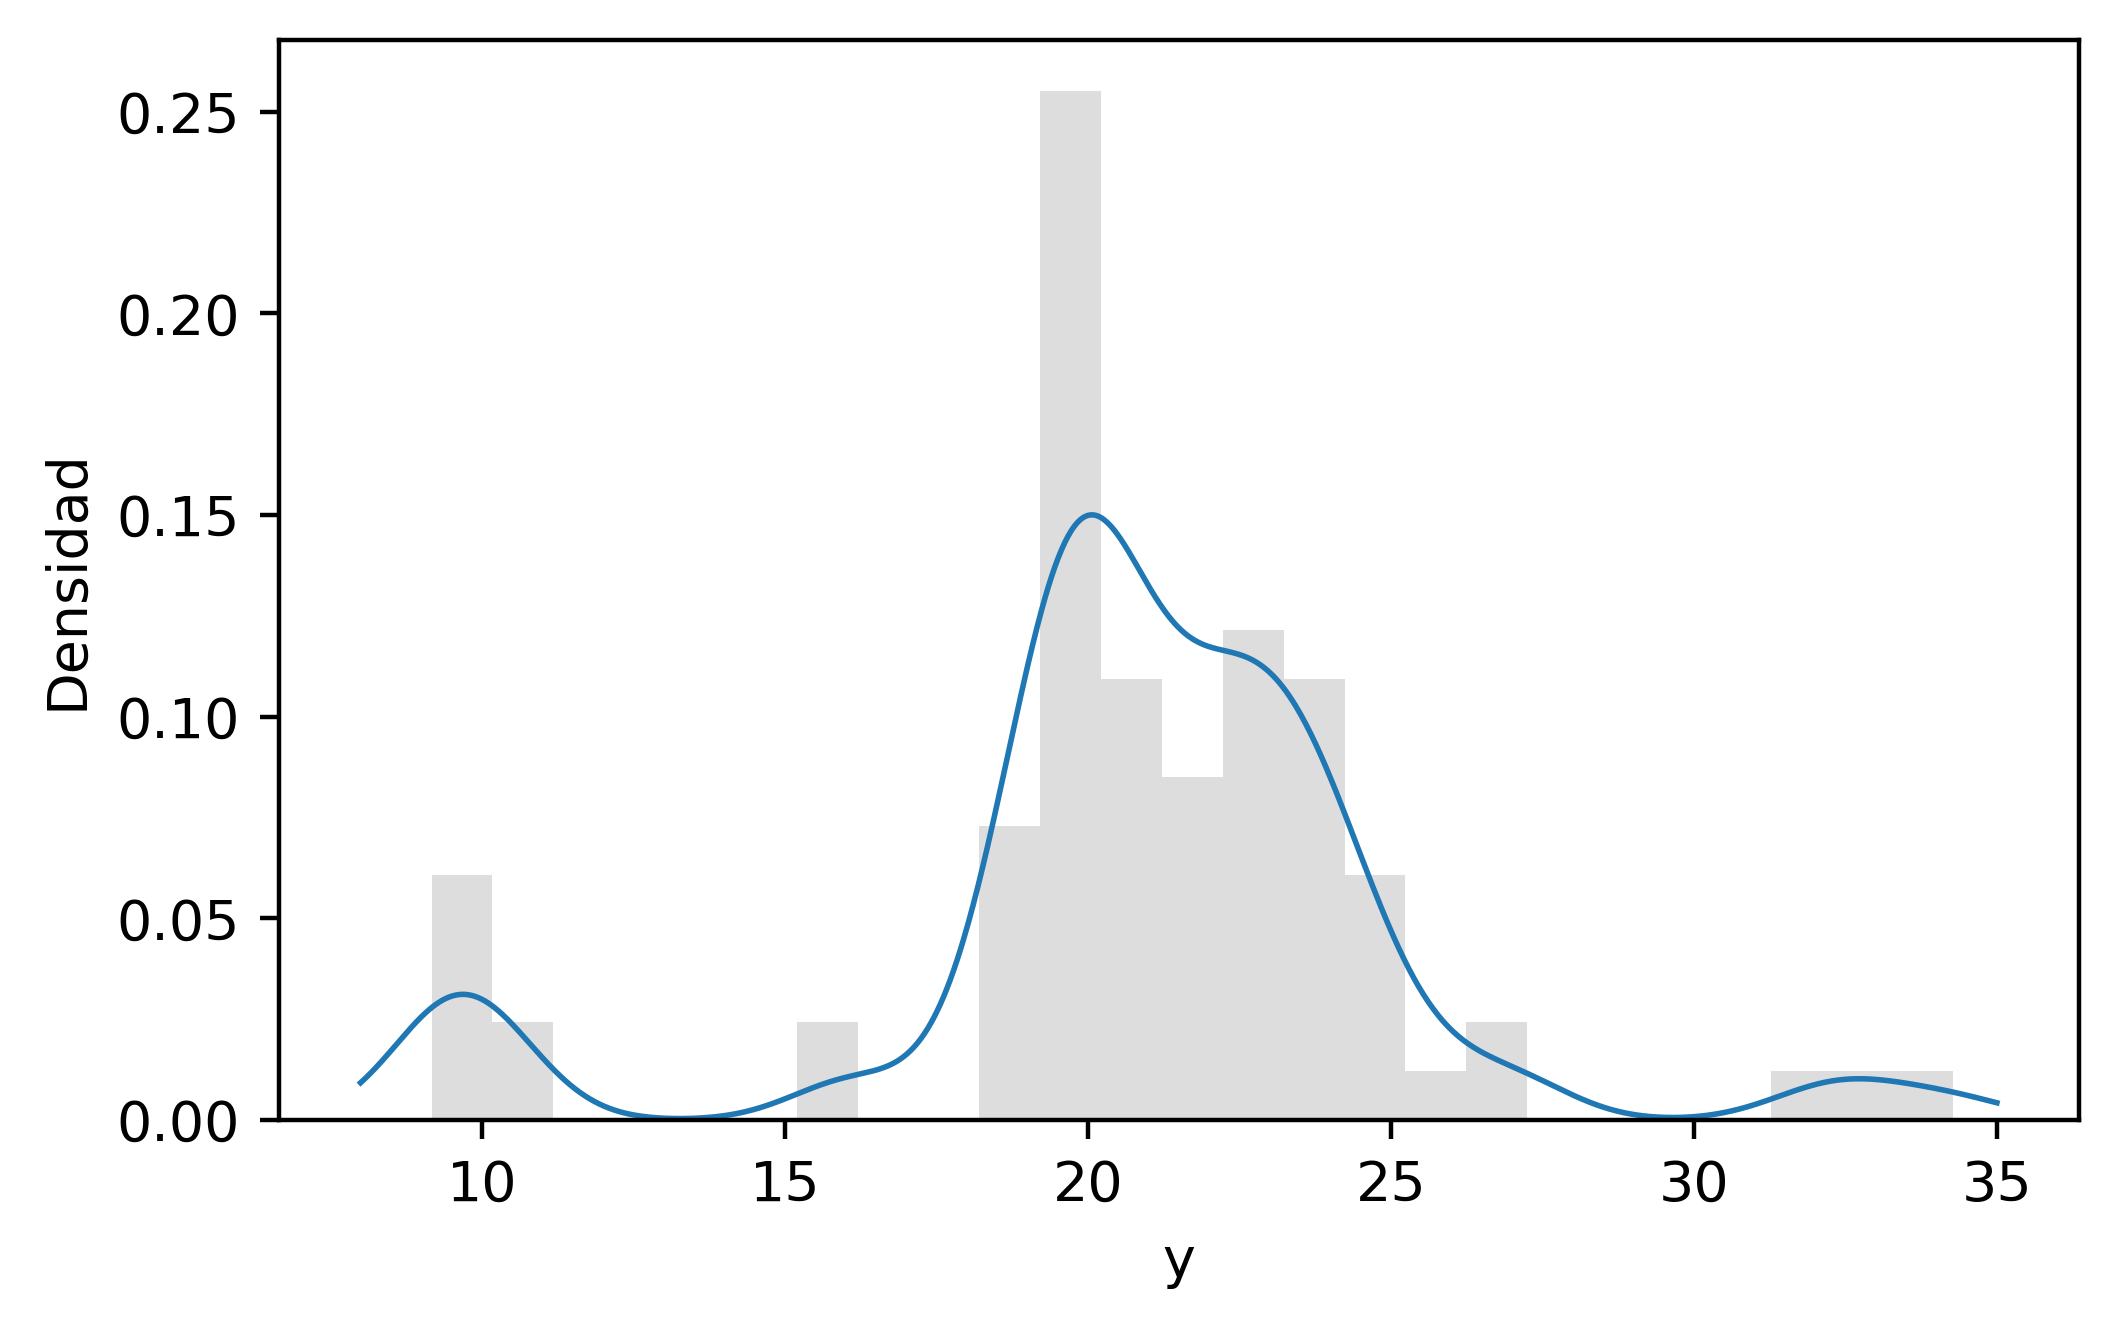

In [43]:
f = plt.figure(figsize = (5,3), dpi = 400)
ax = f.add_axes([0.1,0.1,0.9,0.9])
# histograma
ax.hist(y,color = "#dddddd",bins = 25,density = True)
ax.set_xlabel("y")
ax.set_ylabel("Densidad")
# estimación kernel
y_grid = np.linspace(8,35,num = 1000)
ax.plot(y_grid,st.gaussian_kde(y,bw_method = 0.22)(y_grid),linewidth = 1)
#
plt.show()

### 8.1 Ajuste del modelo

Muestras de la distribución posterior $p(\xiv,\omev,\tev,\sigma^2\mid\yv)$ usando un **muestreador de Gibbs** con:

- $H  = 4$.
- $\alpha^0_1=\ldots=\alpha^0_H=1/H,\mu_0 = 0,\gamma_0^2 = 10,\nu_0 = 1,\sigma^2_0 = 10$. 


In [44]:
# número de grupos
H = 4
# número de iteraciones
n_burn = 1000
n_sams = 2500
# hiperámetros
mu0     = 0
gamma02 = np.var(y,ddof = 1)
nu0     = 1
sig02   = np.var(y,ddof = 1)
# MCMC
np.random.seed(123)
muestras = MCMC_agrupamiento(n_sams, n_burn, y, H = H, alpha0 = np.full(H, 1/H), 
                             mu0 = mu0, gamma02 = gamma02, nu0 = nu0, sig02 = sig02)

0.0% completado
10.0% completado
20.0% completado
30.0% completado
40.0% completado
50.0% completado
60.0% completado
70.0% completado
80.0% completado
90.0% completado


### 8.2 Convergencia

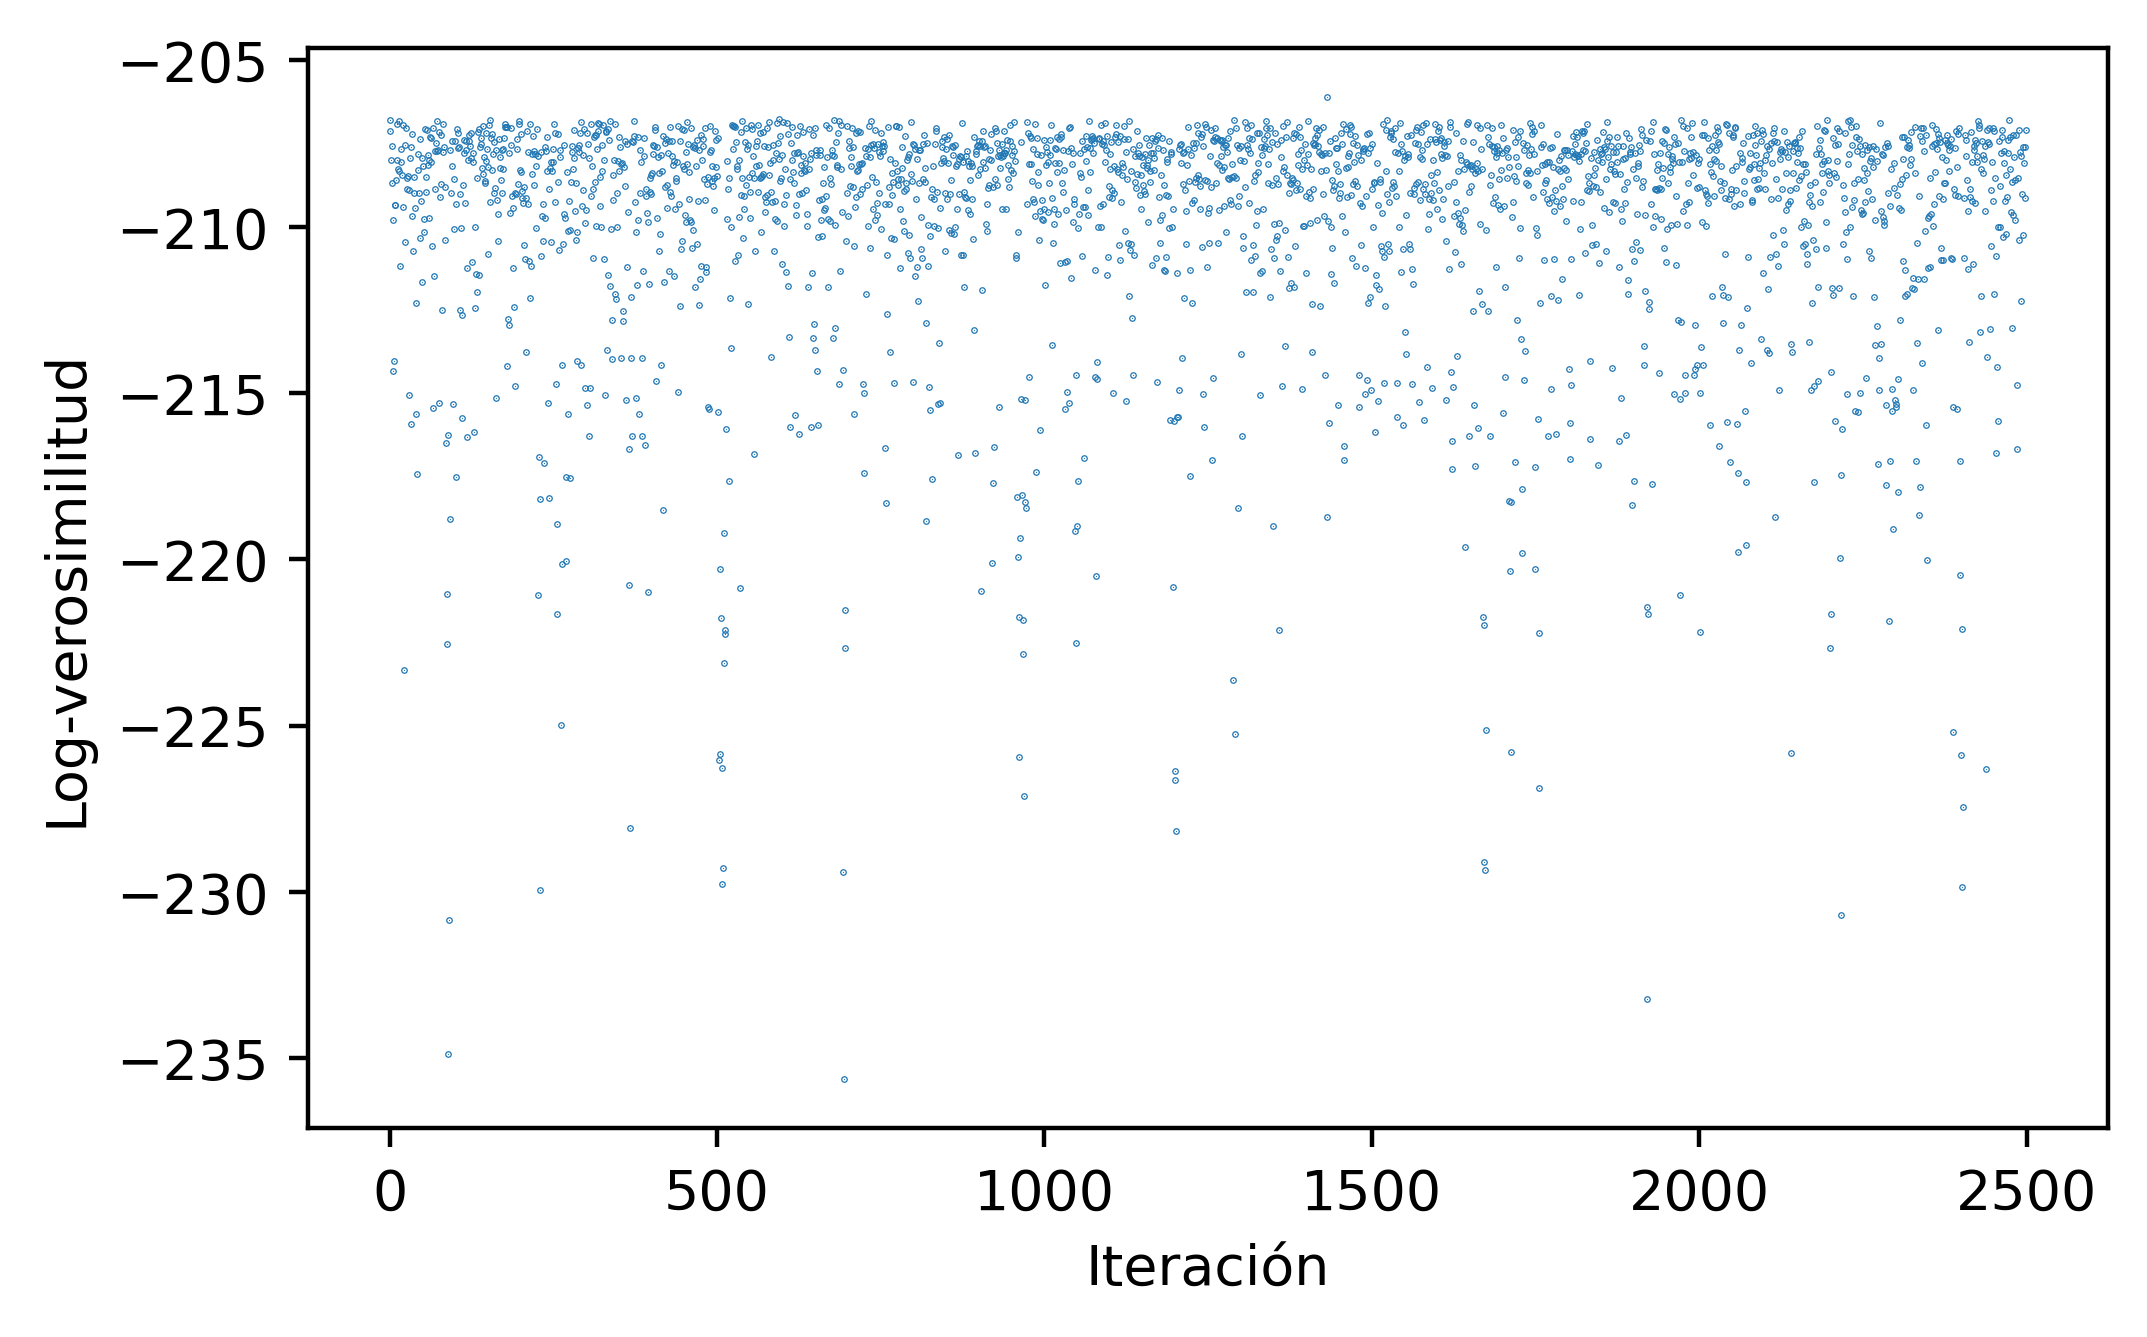

In [45]:
f = plt.figure(figsize = (5,3), dpi = 400)
ax = f.add_axes([0.1,0.1,0.9,0.9])
ax.scatter(range(n_sams),muestras['LP'],s = 0.05)
ax.set_xlabel("Iteración")
ax.set_ylabel("Log-verosimilitud")
plt.show()

In [46]:
# errores estandar de Monte Carlo
neff = [ess(np.array(muestras['THETA'])[:,k]) for k in range(H)]
std = [np.std(np.array(muestras['THETA'])[:,k]) for k in range(H)]
EEMC = std/np.sqrt(neff)
np.round(EEMC,decimals = 5)

array([0.76623, 2.09221, 1.52444, 0.00857])

In [47]:
neff = ess(np.array(muestras['SIG2']))
std = np.std(muestras['SIG2'])
EEMC = std/np.sqrt(neff)
np.round(EEMC,decimals = 5)

0.05202

In [48]:
neff = [ess(np.array(muestras['OMEGA'])[:,k]) for k in range(H)]
std = [np.std(np.array(muestras['OMEGA'])[:,k]) for k in range(H)]
EEMC = std/np.sqrt(neff)
np.round(EEMC,decimals = 5)

array([0.00557, 0.01763, 0.01077, 0.00068])

### 8.3 Inferencia

In [49]:
def nUnique(x):
    return len(np.unique(x))
nc = np.apply_along_axis(nUnique, 1, np.array(muestras['XI']))
pd.DataFrame(nc).value_counts()/B

2    0.8924
3    0.1044
4    0.0032
dtype: float64

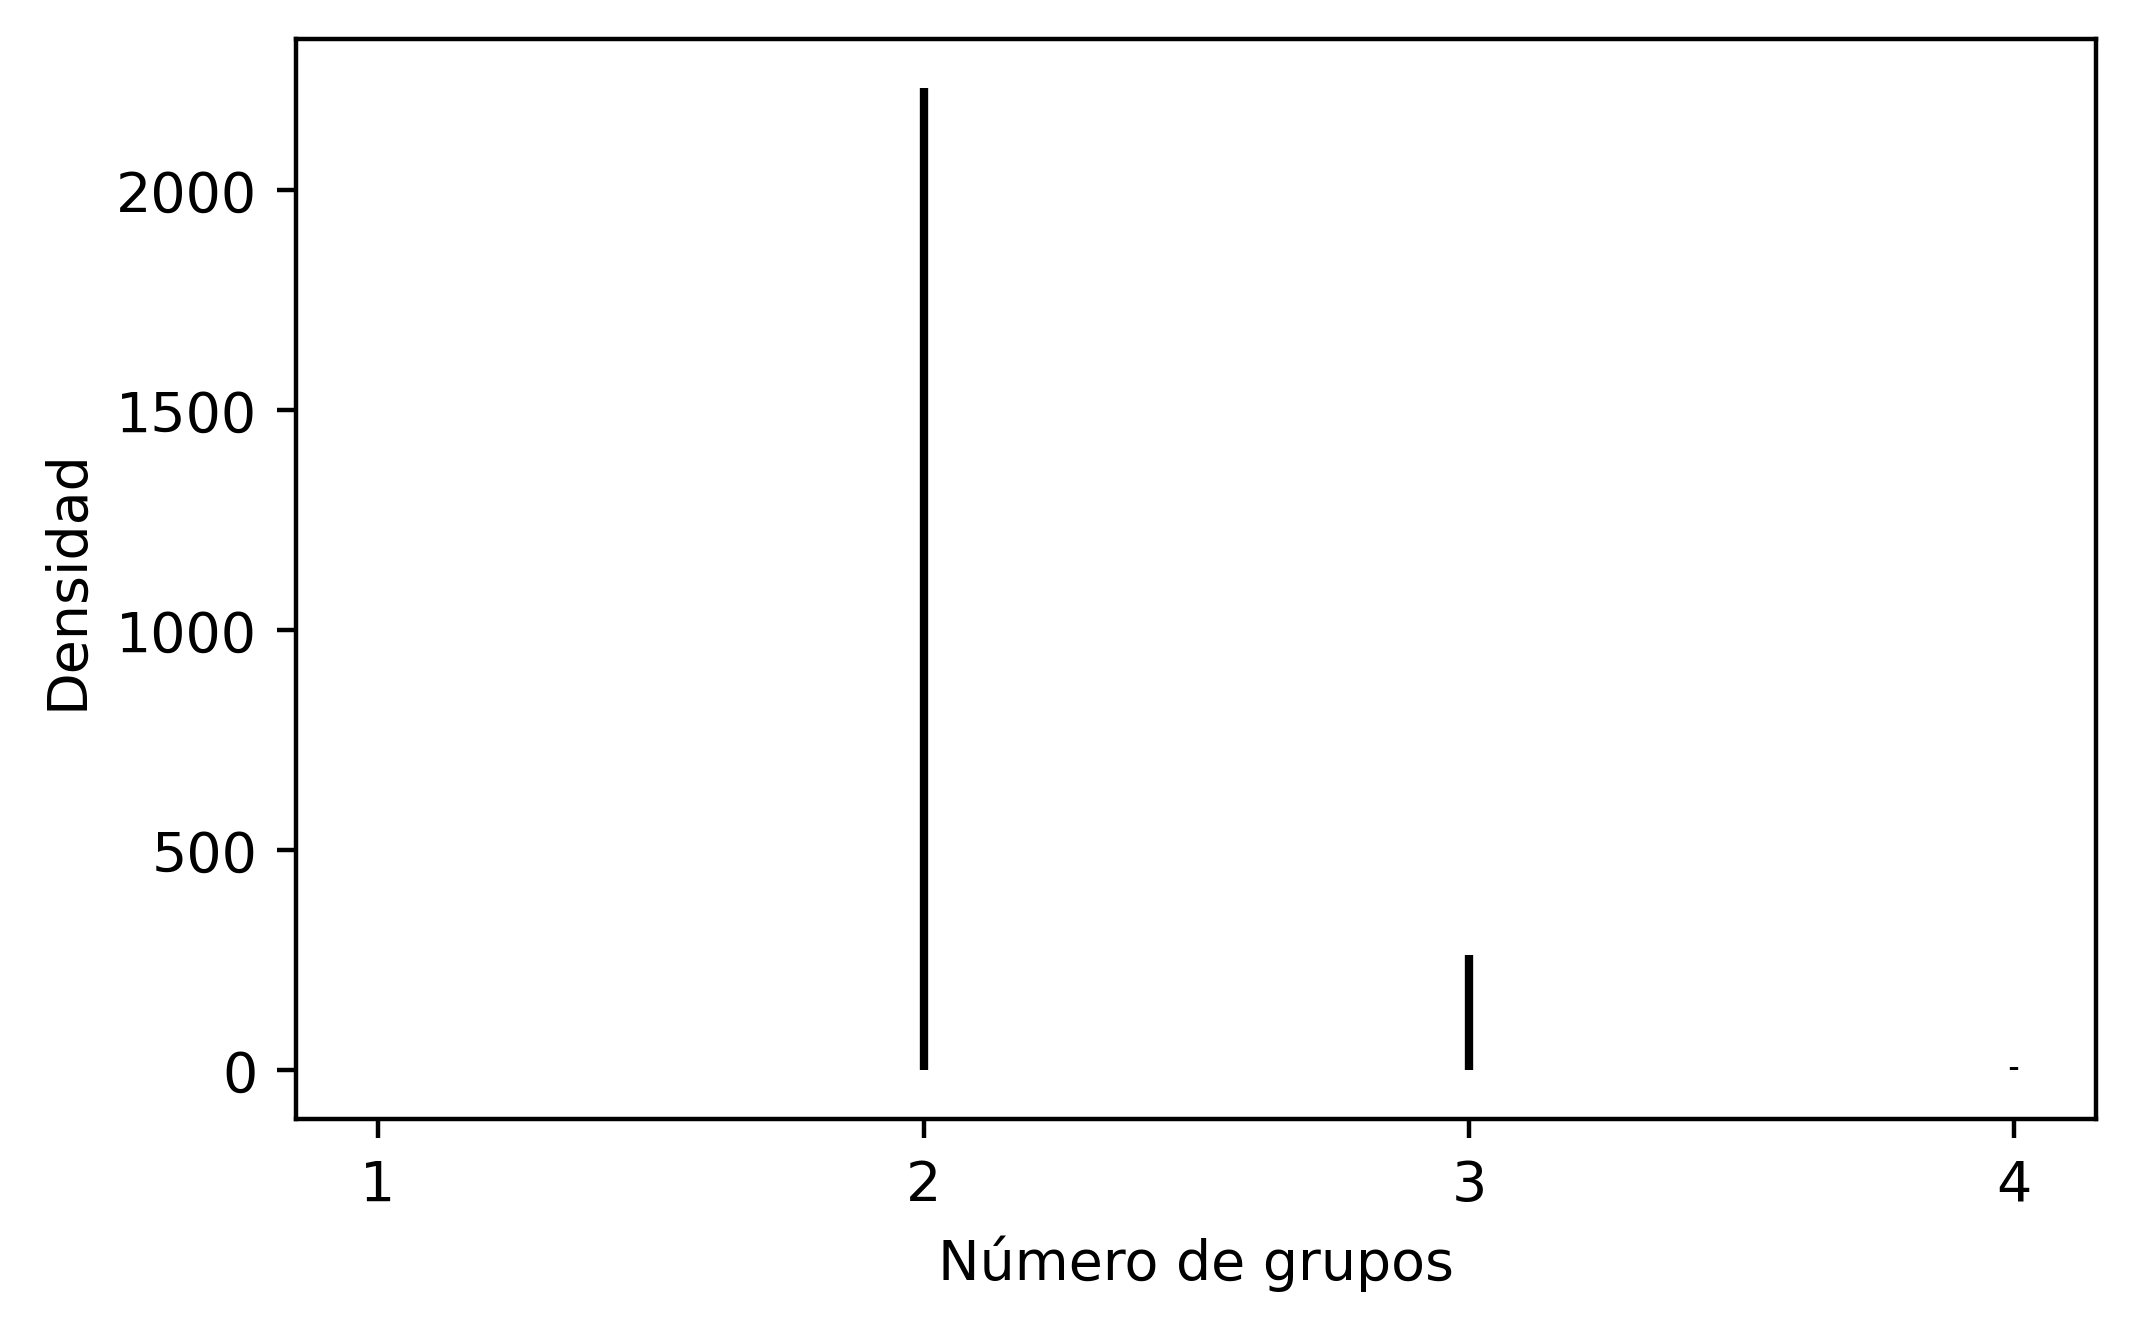

In [50]:
f = plt.figure(figsize = (5,3), dpi = 400)
ax = f.add_axes([0.1,0.1,0.9,0.9])
ax.vlines(x = range(1,5),ymin = 0,ymax = table(nc,5)[1:],color = 'black')
ax.set_xlabel('Número de grupos')
ax.set_ylabel('Densidad')
ax.set_xticks(ticks = [1,2,3,4],labels = [1,2,3,4])
#
plt.show()

In [51]:
# inferencia sobre la función de densidad de la población
M = 100
x0 = np.linspace(9,36,num = M)
B = len(muestras['XI'])
FE = np.empty((B,M))
for i in range(M):
    for b in range(B):
        FE[b,i] = np.sum(
            np.array(muestras['OMEGA'])[b,:]*st.norm.pdf(x0[i],
                                                         np.array(muestras['THETA'])[b,:],
                                                         scale = np.sqrt(muestras['SIG2'][b])
                                                        )
        )
f_hat = np.mean(FE,axis = 0)
f_inf = np.quantile(FE,q = 0.025,axis = 0)
f_sup = np.quantile(FE,q = 0.975,axis = 0)

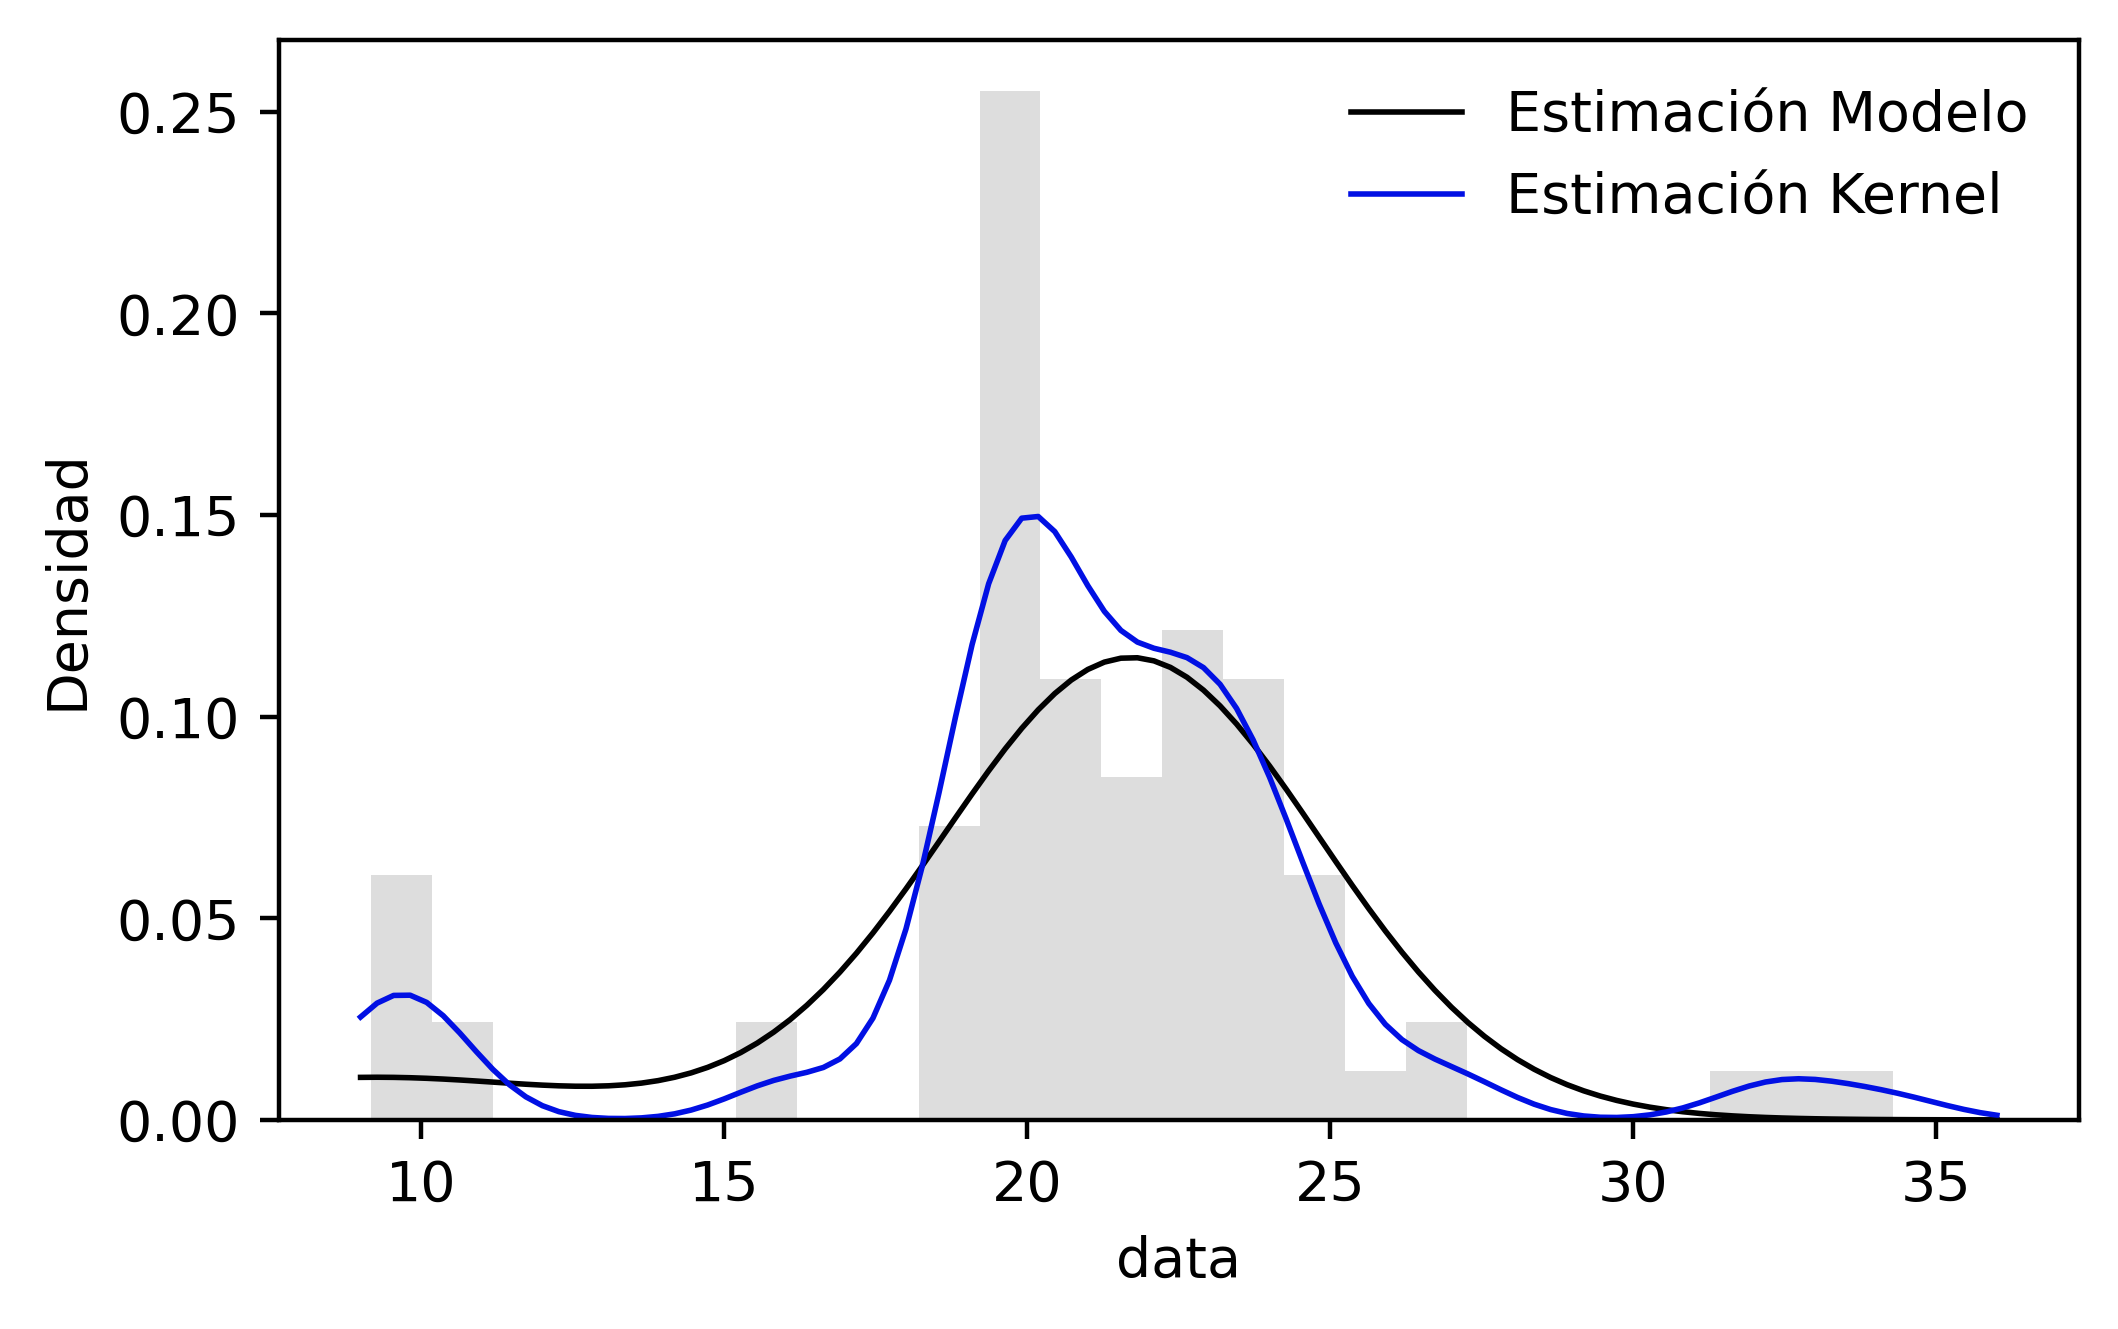

In [52]:
f = plt.figure(figsize = (5,3), dpi = 400)
ax = f.add_axes([0.1,0.1,0.9,0.9])
# histograma
ax.hist(y,color = "#dddddd",bins = 25,density = True)
ax.set_xlabel("data")
ax.set_ylabel("Densidad")
# estimacion modelo
ax.plot(x0,f_hat, color = 'black',linewidth = 1, label = "Estimación Modelo")
# estimación kernel
ax.plot(x0,st.gaussian_kde(y,bw_method = 0.22)(x0),color = '#0110E4',linewidth = 1,label = "Estimación Kernel")
# leyenda
ax.legend(loc = 0, frameon = False)
#
plt.show()

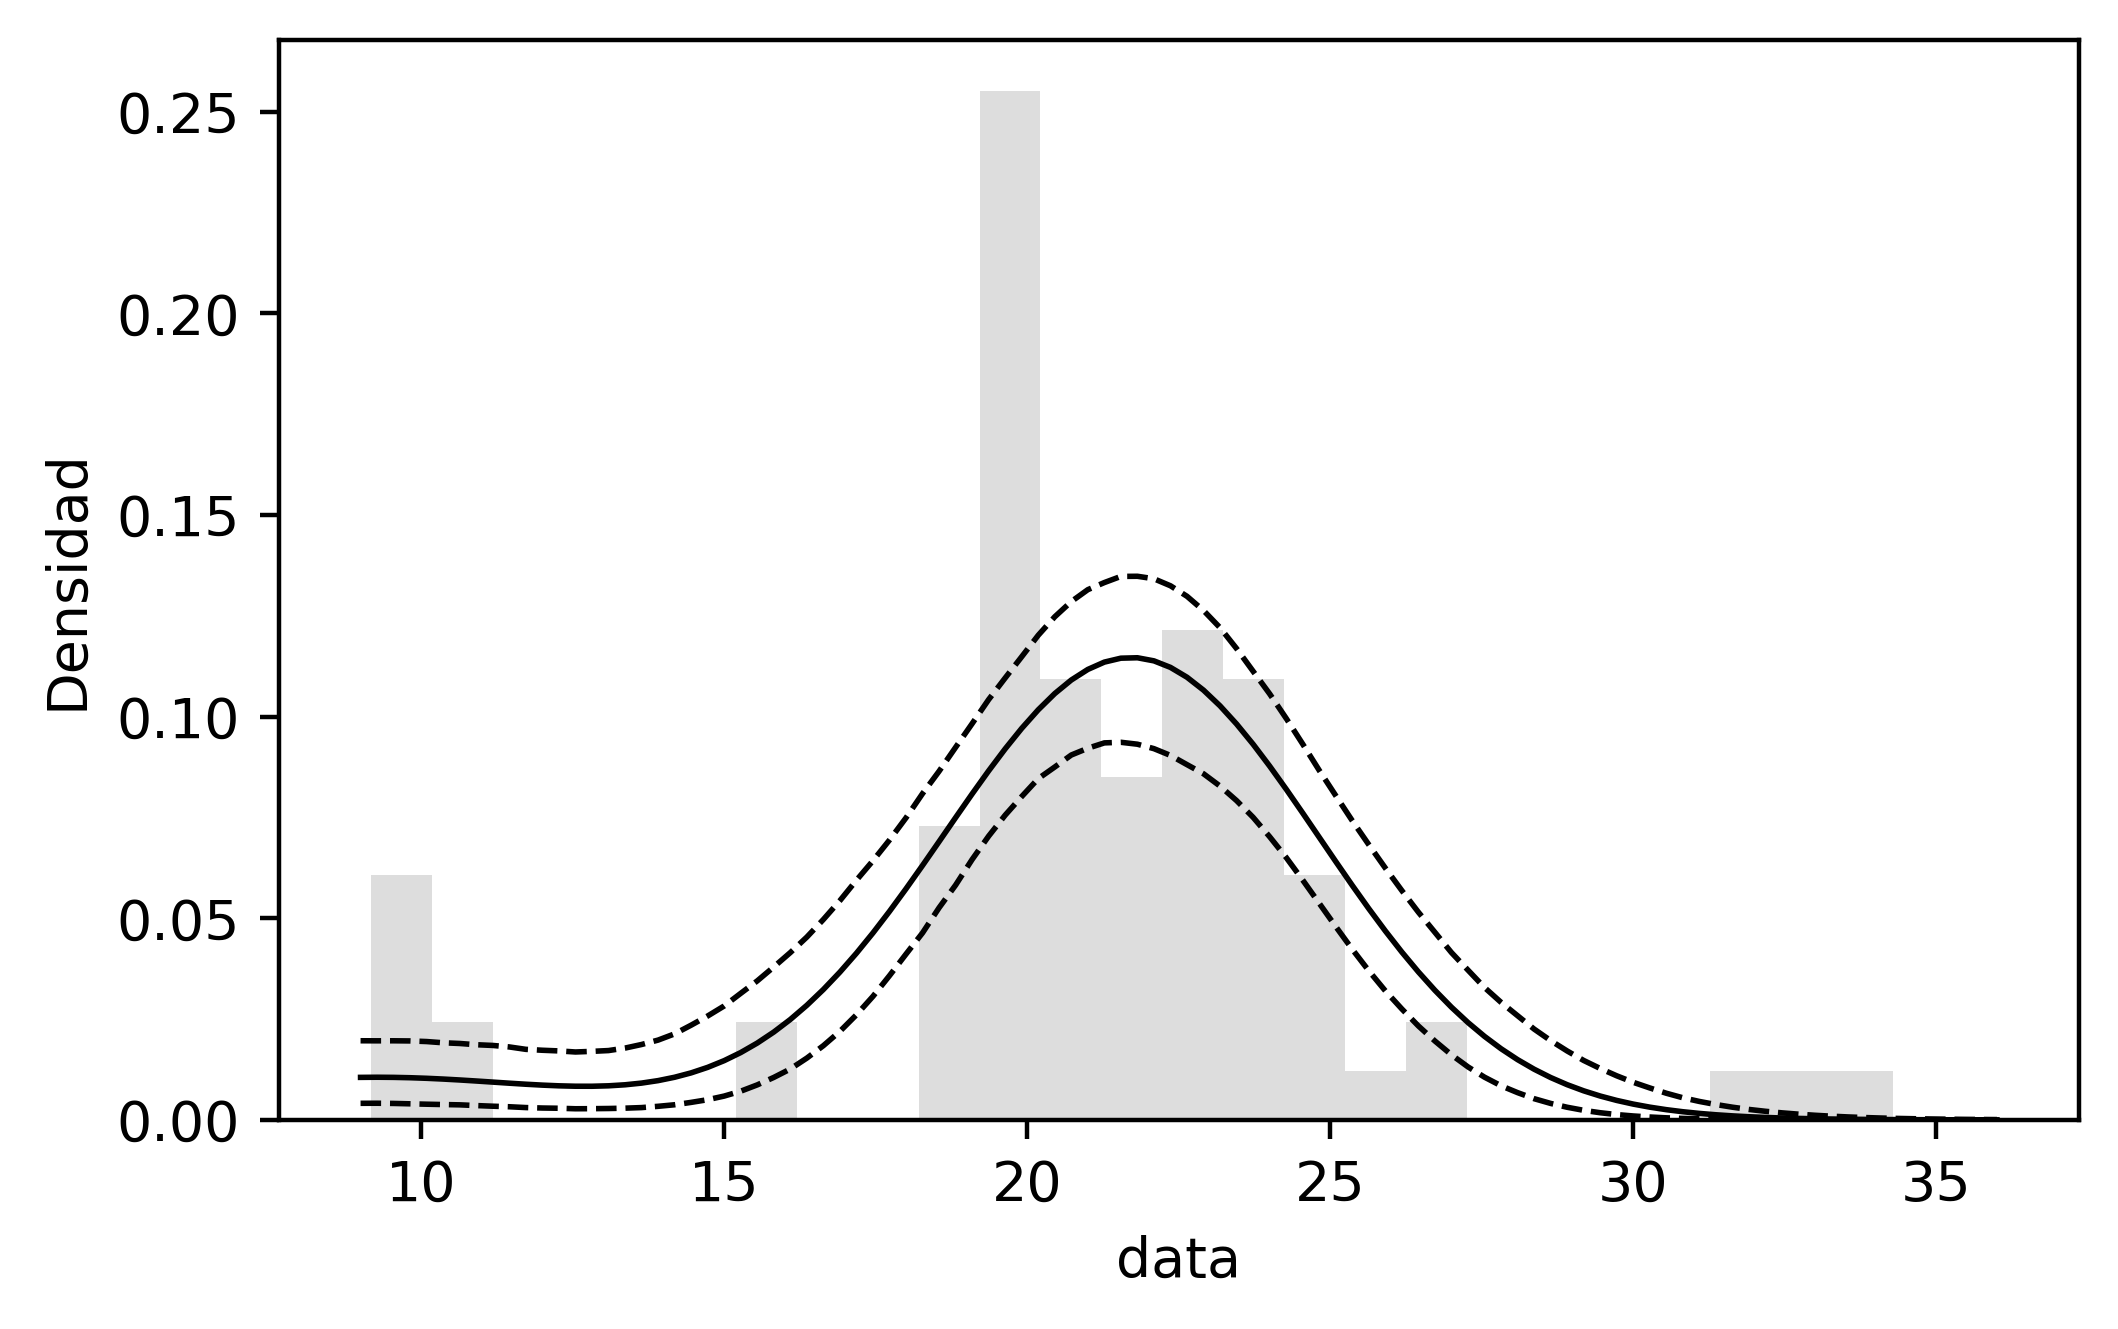

In [53]:
f = plt.figure(figsize = (5,3), dpi = 400)
ax = f.add_axes([0.1,0.1,0.9,0.9])
# histograma
ax.hist(y,color = "#dddddd",bins = 25,density = True)
ax.set_xlabel("data")
ax.set_ylabel("Densidad")
# estimacion modelo
ax.plot(x0,f_inf, color = 'black',linewidth = 1,ls='--')
ax.plot(x0,f_hat, color = 'black',linewidth = 1)
ax.plot(x0,f_sup, color = 'black',linewidth = 1,ls='--')
#
plt.show()

## Referencias

<img src="Hoffcoverbook.jpg" width = 250 />

<img src="Gelmancoverbook.png" width = 250 />

<img src="Reichcoverbook.jpg" width = 250 />